#  orthogonal loss 
This model work well

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import os
import librosa
import numpy as np
from glob import glob
from torch.utils.data import TensorDataset
import torch
import soundfile as sf
import matplotlib.pyplot as plt

def load_flac(file_path, target_sr=16000):
    """Load a FLAC audio file and resample it to the target sample rate."""
    audio, sr = librosa.load(file_path, sr=target_sr)
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val  # Normalize to [-1, 1]
    return audio

def pad_or_trim(audio, target_length=64000):
    """Pad or trim audio to the target length."""
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]
    return audio

def preprocess_dataset(root_dir, target_sr=16000, target_length=64000):
    flac_files = glob(os.path.join(root_dir, '**', '*.flac'), recursive=True)
    print(f"Found {len(flac_files)} .flac files in {root_dir}.")
    if len(flac_files) == 0:
        print("No .flac files found. Please check the root_dir path.")
    dataset = []
    fragmented_count = 0  # Count of fragmented audio files
    sink = []  # Buffer to hold audio fragments less than target_length

    for file in flac_files:
        try:
            audio = load_flac(file, target_sr)
            audio_length = len(audio)
            if audio_length == target_length:
                # Audio is exactly target_length, add directly to dataset
                dataset.append(audio)
            elif audio_length < target_length:
                # Audio is shorter than target_length, add to sink
                fragmented_count += 1
                sink.append(audio)
            else:
                # Audio is longer than target_length
                # Split audio into chunks of target_length
                num_full_chunks = audio_length // target_length
                for i in range(num_full_chunks):
                    chunk = audio[i * target_length : (i + 1) * target_length]
                    dataset.append(chunk)
                # Add any remaining part to the sink
                remainder = audio[num_full_chunks * target_length :]
                if len(remainder) > 0:
                    sink.append(remainder)
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Now, process the sink to create additional samples
    print(f"Number of fragmented audio fragments in sink: {len(sink)}")
    # Keep track of how many additional samples we create
    num_additional_samples = 0

    # Combine fragments in the sink to form new audio samples of target_length
    current_audio = np.array([], dtype=np.float32)
    for fragment in sink:
        current_audio = np.concatenate((current_audio, fragment))
        while len(current_audio) >= target_length:
            # Extract a chunk of target_length
            chunk = current_audio[:target_length]
            dataset.append(chunk)
            num_additional_samples += 1
            # Remove the chunk from current_audio
            current_audio = current_audio[target_length:]

    # Optionally handle the last remaining fragment
    # Decide whether to discard or pad the last fragment
    if len(current_audio) > 0:
        # You can choose to discard it or pad it to target_length
        # Here we pad it and add it to the dataset
        padded_audio = pad_or_trim(current_audio, target_length)
        dataset.append(padded_audio)
        num_additional_samples += 1

    print(f"Number of additional samples created from sink fragments: {num_additional_samples}")
    print(f"Total number of audio samples in dataset: {len(dataset)}")

    dataset = torch.tensor(dataset, dtype=torch.float32)
    return TensorDataset(dataset)

def save_waveform_to_audio(waveform, sample_rate, filename):
    """
    Save a waveform to an audio file.
    """
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.detach().cpu().numpy()
    
    waveform = np.squeeze(waveform)
    max_val = np.max(np.abs(waveform))
    if max_val > 0:
        waveform = waveform / max_val
    
    sf.write(filename, waveform, sample_rate)

def verify_waveform_to_audio(root_dir, sample_rate=16000, target_length=64000, output_dir="verified_audio"):
    """
    Verify waveform-to-audio conversion using preprocessed dataset.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dataset = preprocess_dataset(root_dir, sample_rate, target_length)
    
    num_samples_to_verify = min(5, len(dataset))
    
    for idx in range(num_samples_to_verify):
        waveform = dataset.tensors[0][idx]
        
        filename = os.path.join(output_dir, f"example_waveform_{idx+1}.wav")
        save_waveform_to_audio(waveform, sample_rate, filename)
        print(f"Waveform saved to {filename}")
        
        # Plot the waveform
        plt.figure(figsize=(12, 4))
        plt.plot(waveform.numpy())
        plt.title(f"Waveform {idx+1}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.show()


Found 2703 .flac files in ./data.
Number of fragmented audio fragments in sink: 2699
Number of additional samples created from sink fragments: 1422
Total number of audio samples in dataset: 4850


/tmp/ipykernel_6410/91943476.py:89: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  dataset = torch.tensor(dataset, dtype=torch.float32)


Waveform saved to verified_audio/example_waveform_1.wav


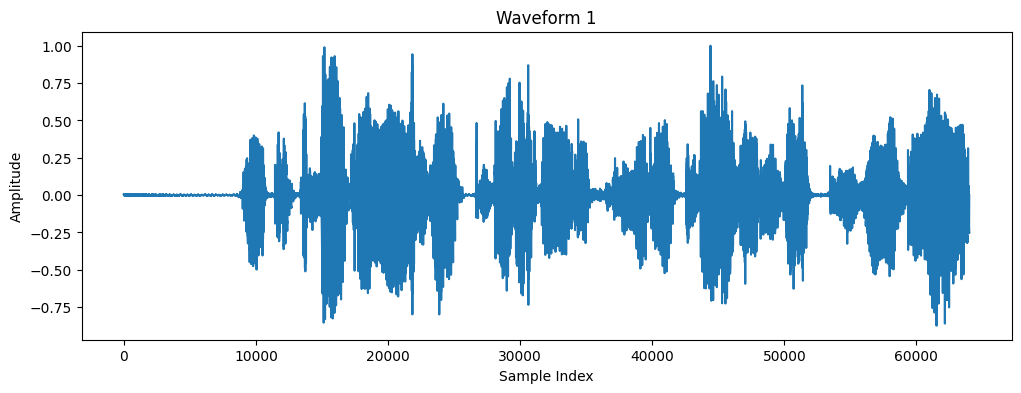

Waveform saved to verified_audio/example_waveform_2.wav


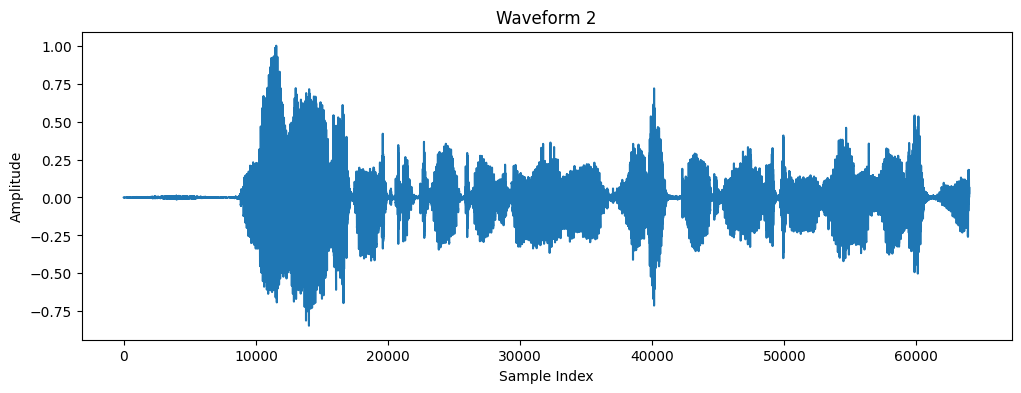

Waveform saved to verified_audio/example_waveform_3.wav


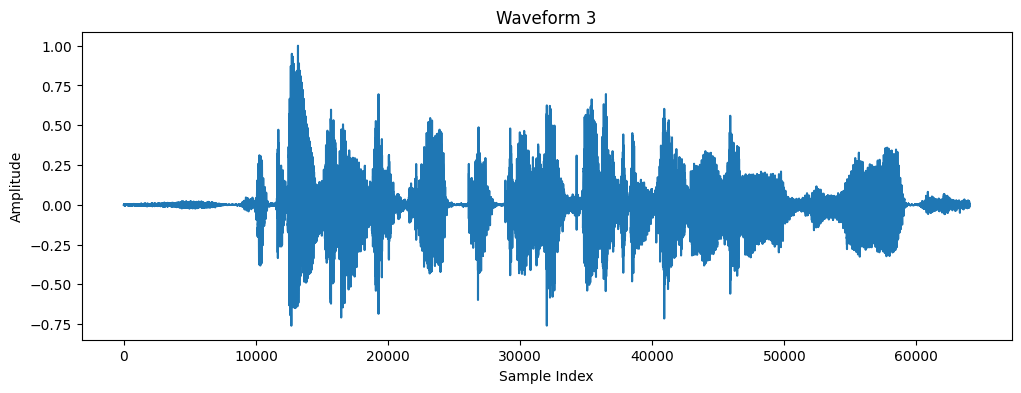

Waveform saved to verified_audio/example_waveform_4.wav


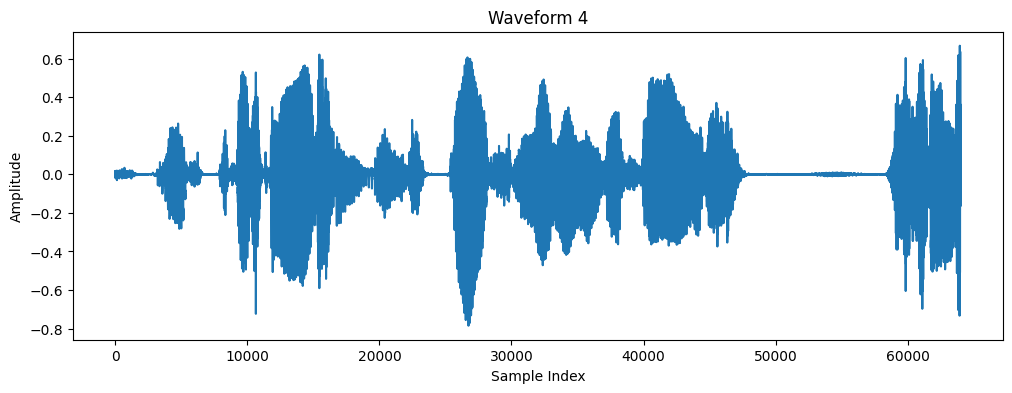

Waveform saved to verified_audio/example_waveform_5.wav


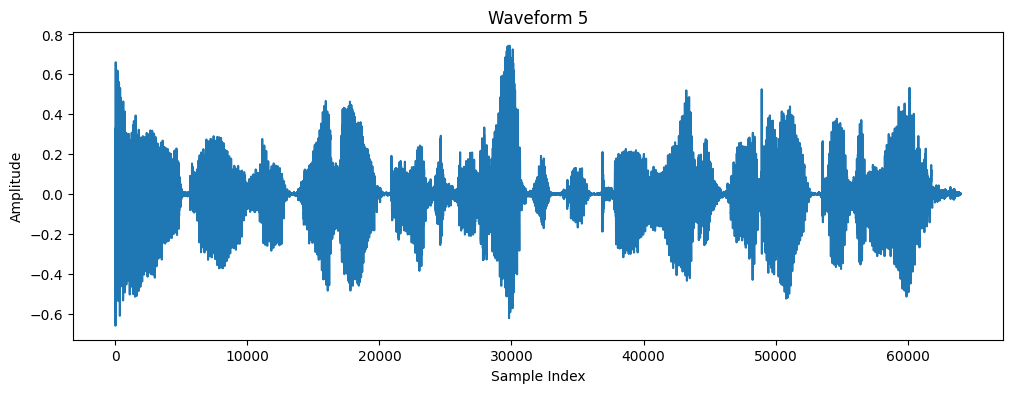

In [3]:
audio_length = 64000  # Set this to your actual audio waveform length
root_dir = "./data"  # Replace with your actual data directory
verify_waveform_to_audio(root_dir, sample_rate=16000, target_length=64000, output_dir="verified_audio")



In [4]:
import math
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Turn off the cuDNN auto-tuner to avoid nondeterministic behavior


# img_size = 28
# img_channels = 1

def get_dim_for_each_layer(z_dim, total_l, l, output_dim):
    """
    Calculate the dimension for the l-th layer in the generator.

    Parameters:
    - z_dim: int, the input dimension (e.g., latent vector size).
    - total_l: int, the total number of layers in the generator.
    - l: int, the current layer index (1-indexed).
    - output_dim: int, the final output dimension (e.g., audio length).

    Returns:
    - int: the calculated dimension for the l-th layer.
    """
    if l < 1 or l > total_l:
        raise ValueError("Layer index 'l' must be in the range [1, total_l].")
    if l == total_l:
        return output_dim
    if l == 1:
        return z_dim
    # Calculate the dimension change per layer
    step = (output_dim - z_dim) / (total_l - 1)
    
    # Compute the dimension for the l-th layer
    dim = z_dim + (l - 1) * step
    return math.ceil(dim)  # Use math.ceil to round up to an integer
    

In [5]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, audio_length):
        super(Generator, self).__init__()

        self.initial_length = audio_length // 256  # 64000 / 256 = 250
        self.model = nn.Sequential(
            nn.Linear(z_dim, 512 * self.initial_length),  # Output: (batch_size, 512 * 250)
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (512, self.initial_length)),  # Shape: (batch_size, 512, 250)
            nn.ConvTranspose1d(512, 256, kernel_size=25, stride=4, padding=11, output_padding=1),  # Output length: 1000
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(256, 128, kernel_size=25, stride=4, padding=11, output_padding=1),  # Output length: 4000
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(128, 64, kernel_size=25, stride=4, padding=11, output_padding=1),   # Output length: 16000
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 1, kernel_size=25, stride=4, padding=11, output_padding=1),     # Output length: 64000
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)









class Discriminator(nn.Module):
    def __init__(self, audio_length):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=25, stride=4, padding=11),  # Output: (batch_size, 64, L1)
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=11),  # Output: (batch_size, 128, L2)
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=11),  # Output: (batch_size, 256, L3)
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 512, kernel_size=25, stride=4, padding=11),  # Output: (batch_size, 512, L4)
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool1d(1),  # Output: (batch_size, 512, 1)
            nn.Flatten(),             # Output: (batch_size, 512)
            nn.Linear(512, 1)
        )

    def forward(self, x):
        # Remove the unnecessary unsqueeze
        # x = x.unsqueeze(1)  # This line is removed
        return self.model(x)





class Encoder(nn.Module):
    def __init__(self, audio_length):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool1d(1),  # Output: (batch_size, 128, 1)
            nn.Flatten(),             # Output: (batch_size, 128)
            nn.Linear(128, 64)        # Output: (batch_size, 64)
        )

    def forward(self, x):
        # x = x.unsqueeze(1)  # Remove if input x already has channel dimension
        return self.encoder(x)





# Loss function
criterion = nn.BCELoss()

In [6]:
# batch_size = 64
# z_dim = 100
# audio_length = 64000

# generator = Generator(z_dim, audio_length)
# discriminator = Discriminator(audio_length)

# # Generate fake audio
# noise = torch.randn(batch_size, z_dim)
# fake_audio = generator(noise)

# # Pass fake audio through the discriminator
# disc_output = discriminator(fake_audio)

# print(f"Fake audio shape: {fake_audio.shape}")         # Expected: (batch_size, 1, 64000)
# print(f"Discriminator output shape: {disc_output.shape}")  # Expected: (batch_size, 1)


In [7]:
def generate_noise(batch_size, z_dim, device):
    return torch.randn(batch_size, z_dim).to(device)

# Orthogonal loss function
def orthogonal_loss(feature1, feature2):
    inner_product = torch.sum(feature1 * feature2, dim=1)
    norm1 = torch.norm(feature1, dim=1)
    norm2 = torch.norm(feature2, dim=1)
    cosine_similarity = inner_product / (norm1 * norm2 + 1e-8)
    return torch.mean(cosine_similarity**2)  # Minimize the cosine similarity to make vectors orthogonal


In [8]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)

    # Sample epsilon uniformly in [0,1]
    epsilon = torch.rand(batch_size, 1, 1, device=device)
    epsilon = epsilon.expand_as(real_samples)

    # Interpolate between real and fake samples
    interpolates = (epsilon * real_samples + (1 - epsilon) * fake_samples).requires_grad_(True)
    interpolates_output = critic(interpolates)

    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=interpolates_output,
        inputs=interpolates,
        grad_outputs=torch.ones_like(interpolates_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Reshape gradients
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty


In [9]:
import matplotlib.pyplot as plt

def visualize_and_save_generated_waveforms(generators, z_dim, num_waveforms, device,epoch, sample_rate=16000, output_dir='generated_audio'):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    noise = generate_noise(num_waveforms, z_dim, device)
    for idx, gen in enumerate(generators):
        fake_waveforms = gen(noise).detach().cpu().numpy()
        for i in range(num_waveforms):
            waveform = fake_waveforms[i]
            # Save each waveform to an audio file
            filename = f'epoch{epoch+1}_gen{idx+1}_sample{i+1}.wav'
            filepath = os.path.join(output_dir, filename)
            save_waveform_to_audio(waveform, sample_rate, filepath)
            print(f"Saved {filepath}")



In [ ]:

train_dataset = preprocess_dataset(root_dir="./data", target_sr=16000, target_length=audio_length)

Found 2703 .flac files in ./data.


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

def pretrain_single_generator(num_epochs, z_dim, lr_gen, lr_disc, batch_size, seed, audio_length, output_dir, train_dataset):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Check for device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define the single generator and discriminator
    generator = Generator(z_dim, audio_length).to(device)
    discriminator = Discriminator(audio_length).to(device)

    optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.9))
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))

    # Load and preprocess the audio dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    lambda_gp = 10  # Gradient penalty coefficient
    num_critic = 5  # Number of discriminator updates per generator update

    # To track the losses
    loss_disc_history = []
    loss_gen_history = []

    # Training loop
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()  # Clear unused memory
        loss_disc_epoch = 0
        loss_gen_epoch = 0

        for batch_idx, (real,) in enumerate(train_loader):
            real = real.to(device)
            batch_size = real.size(0)
            if real.dim() == 2:
                real = real.unsqueeze(1)  # Add channel dimension (batch_size, 1, audio_length)

            #print(f"real shape: {real.shape}")

            # Train Discriminator multiple times
            for _ in range(num_critic):
                optimizer_disc.zero_grad()

                # Generate fake data
                noise = generate_noise(batch_size, z_dim, device)
                fake = generator(noise).detach()

                # Compute discriminator outputs
                disc_real = discriminator(real)
                disc_fake = discriminator(fake)

                # Compute Wasserstein loss
                loss_disc_real = -torch.mean(disc_real)
                loss_disc_fake = torch.mean(disc_fake)
                loss_disc = loss_disc_real + loss_disc_fake

                # Compute gradient penalty
                gradient_penalty = compute_gradient_penalty(discriminator, real.data, fake.data, device)
                loss_disc += lambda_gp * gradient_penalty

                loss_disc.backward()
                optimizer_disc.step()

            loss_disc_epoch += loss_disc.item()

            # Train Generator
            optimizer_gen.zero_grad()
            noise = generate_noise(batch_size, z_dim, device)
            fake = generator(noise)
            disc_fake = discriminator(fake)
            loss_gen = -torch.mean(disc_fake)
            loss_gen.backward()
            optimizer_gen.step()

            loss_gen_epoch += loss_gen.item()

        avg_loss_disc = loss_disc_epoch / len(train_loader)
        avg_loss_gen = loss_gen_epoch / len(train_loader)

        # Record the losses
        loss_disc_history.append(avg_loss_disc)
        loss_gen_history.append(avg_loss_gen)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}, Loss G: {avg_loss_gen:.4f}")

        # Visualize generated waveforms
        visualize_and_save_generated_waveforms(
            [generator], z_dim, num_waveforms=5, device=device, epoch=epoch, sample_rate=16000, output_dir=output_dir
        )

    # Save the generator model
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    torch.save(generator.state_dict(), os.path.join(output_dir, "pretrained_generator.pth"))
    print(f"Pretrained generator model saved to {os.path.join(output_dir, 'pretrained_generator.pth')}")

    # Plot the learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(loss_disc_history, label="Discriminator Loss")
    plt.plot(loss_gen_history, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "learning_curves.png"))
    plt.show()

    return generator


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import librosa
import librosa.display
import soundfile as sf
import os
from torch.nn.utils import spectral_norm
import torch.autograd as autograd
# Wasserstein loss
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_pred * y_true)

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    batch_size = real_data.size(0)
    # Corrected epsilon shape to match real_data dimensions
    epsilon = torch.rand(batch_size, 1, 1, device=device)  # Shape: [batch_size, 1, 1]
    epsilon = epsilon.expand_as(real_data)  # Now expands to [batch_size, 1, audio_length]
    
    # Interpolate between real and fake data
    interpolates = epsilon * real_data + (1 - epsilon) * fake_data
    interpolates = interpolates.requires_grad_(True)
    
    # Compute discriminator output
    disc_interpolates = discriminator(interpolates)
    
    # Compute gradients
    grad_outputs = torch.ones_like(disc_interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Reshape gradients
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import os

def train_gan_with_pretrained_generators(
    pretrained_generator, num_epochs, z_dim, lr_gen, lr_disc, batch_size, train_dataset,
    num_generators, seed, audio_length, output_dir, lambda_gp=10, lambda_ortho=0.1, num_critic=5,
    checkpoint_dir='checkpoints', resume=True
):
    import os

    # Set the seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize multiple generators with the pretrained generator
    generators = []
    for _ in range(num_generators):
        gen = Generator(z_dim, audio_length).to(device)
        gen.load_state_dict(pretrained_generator.state_dict())
        generators.append(gen)

    # Initialize Discriminator
    discriminator = Discriminator(audio_length).to(device)

    optimizer_gens = [optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.9)) for gen in generators]
    optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.9))

    # Initialize Encoder only if lambda_ortho > 0
    if lambda_ortho > 0:
        encoder = Encoder(audio_length).to(device)
        optimizer_encoder = optim.Adam(encoder.parameters(), lr=lr_disc, betas=(0.5, 0.9))
    else:
        encoder = None
        optimizer_encoder = None

    # Load and preprocess the audio dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Check for existing checkpoint
    start_epoch = 0
    if resume and os.path.exists(os.path.join(checkpoint_dir, 'checkpoint.pth')):
        print("Resuming from checkpoint...")
        checkpoint = torch.load(os.path.join(checkpoint_dir, 'checkpoint.pth'), map_location=device)
        start_epoch = checkpoint['epoch'] + 1  # Next epoch to start from

        # Load models
        for idx, gen in enumerate(generators):
            gen.load_state_dict(checkpoint['generator_state_dicts'][idx])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        if lambda_ortho > 0:
            encoder.load_state_dict(checkpoint['encoder_state_dict'])

        # Load optimizers
        for idx, optimizer_gen in enumerate(optimizer_gens):
            optimizer_gen.load_state_dict(checkpoint['optimizer_gens_state_dicts'][idx])
        optimizer_disc.load_state_dict(checkpoint['optimizer_disc_state_dict'])
        if lambda_ortho > 0:
            optimizer_encoder.load_state_dict(checkpoint['optimizer_encoder_state_dict'])

        # Load loss histories
        loss_disc_history = checkpoint['loss_disc_history']
        loss_gens_history = checkpoint['loss_gens_history']

    else:
        print("Starting training from scratch.")
        start_epoch = 0
        # Initialize loss histories
        loss_disc_history = []
        loss_gens_history = [[] for _ in range(num_generators)]

    # Training loop
    try:
        for epoch in range(start_epoch, num_epochs):
            torch.cuda.empty_cache()
            loss_disc_epoch = 0
            loss_gens_epoch = [0] * num_generators

            for batch_idx, (real,) in enumerate(train_loader):
                real = real.to(device)
                if real.dim() == 2:
                    real = real.unsqueeze(1)  # Add channel dimension (batch_size, 1, audio_length)
                batch_size = real.size(0)
                real_label = -torch.ones(batch_size, 1, device=device)
                fake_label = torch.ones(batch_size, 1, device=device)

                real = real + 0.001 * torch.randn_like(real)

                # Train Discriminator multiple times
                for _ in range(num_critic):
                    optimizer_disc.zero_grad()

                    disc_real = discriminator(real)

                    noises = [generate_noise(batch_size, z_dim, device) for _ in range(num_generators)]
                    fakes = [gen(noises[idx]).detach() for idx, gen in enumerate(generators)]

                    for idx in range(num_generators):
                        fakes[idx] = fakes[idx] + 0.001 * torch.randn_like(fakes[idx])

                    disc_fakes = [discriminator(fake) for fake in fakes]

                    # Average the fake losses
                    loss_disc_fake = sum(wasserstein_loss(disc_fake, fake_label) for disc_fake in disc_fakes) / num_generators
                    loss_disc_real = wasserstein_loss(disc_real, real_label)
                    loss_disc = loss_disc_real + loss_disc_fake

                    # Average gradient penalty
                    gradient_penalty = sum(
                        compute_gradient_penalty(discriminator, real, fake, device) for fake in fakes
                    ) / num_generators
                    loss_disc += lambda_gp * gradient_penalty

                    loss_disc.backward()
                    optimizer_disc.step()

                loss_disc_epoch += loss_disc.item()

                # Train Generators
                for idx, gen in enumerate(generators):
                    optimizer_gens[idx].zero_grad()
                    if lambda_ortho > 0:
                        optimizer_encoder.zero_grad()

                    noise = generate_noise(batch_size, z_dim, device)
                    fake = gen(noise)
                    disc_fake = discriminator(fake)

                    loss_gen = wasserstein_loss(disc_fake, real_label)

                    if lambda_ortho > 0:
                        # Compute orthogonal loss
                        gen_feature = encoder(fake)
                        ortho_loss_total = 0
                        for other_idx, other_gen in enumerate(generators):
                            if idx != other_idx:
                                other_noise = generate_noise(batch_size, z_dim, device)
                                other_fake = other_gen(other_noise)
                                other_feature = encoder(other_fake)
                                ortho_loss = orthogonal_loss(gen_feature, other_feature)
                                ortho_loss_total += ortho_loss

                        ortho_loss_total /= (num_generators - 1)
                        total_loss_gen = loss_gen + lambda_ortho * ortho_loss_total
                    else:
                        total_loss_gen = loss_gen

                    total_loss_gen.backward()
                    optimizer_gens[idx].step()

                    if lambda_ortho > 0:
                        optimizer_encoder.step()

                    loss_gens_epoch[idx] += total_loss_gen.item()

            avg_loss_disc = loss_disc_epoch / len(train_loader)
            avg_loss_gens = [loss / len(train_loader) for loss in loss_gens_epoch]

            print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_loss_disc:.4f}")
            for idx in range(num_generators):
                print(f"Loss G{idx+1}: {avg_loss_gens[idx]:.4f}")
            print('-' * 50)

            # Record the losses
            loss_disc_history.append(avg_loss_disc)
            for idx in range(num_generators):
                loss_gens_history[idx].append(avg_loss_gens[idx])

            # Visualize generated waveforms
            visualize_and_save_generated_waveforms(
                generators, z_dim, num_waveforms=5, device=device, epoch=epoch, sample_rate=16000, output_dir=output_dir
            )

            # Save checkpoint after each epoch
            checkpoint = {
                'epoch': epoch,
                'generator_state_dicts': [gen.state_dict() for gen in generators],
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_gens_state_dicts': [opt.state_dict() for opt in optimizer_gens],
                'optimizer_disc_state_dict': optimizer_disc.state_dict(),
                'loss_disc_history': loss_disc_history,
                'loss_gens_history': loss_gens_history
            }
            if lambda_ortho > 0:
                checkpoint['encoder_state_dict'] = encoder.state_dict()
                checkpoint['optimizer_encoder_state_dict'] = optimizer_encoder.state_dict()

            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            torch.save(checkpoint, os.path.join(checkpoint_dir, 'checkpoint.pth'))
            print(f"Checkpoint saved at epoch {epoch}")

    except KeyboardInterrupt:
        print(f"Training interrupted at epoch {epoch}. Saving checkpoint...")
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'generator_state_dicts': [gen.state_dict() for gen in generators],
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_gens_state_dicts': [opt.state_dict() for opt in optimizer_gens],
            'optimizer_disc_state_dict': optimizer_disc.state_dict(),
            'loss_disc_history': loss_disc_history,
            'loss_gens_history': loss_gens_history
        }
        if lambda_ortho > 0:
            checkpoint['encoder_state_dict'] = encoder.state_dict()
            checkpoint['optimizer_encoder_state_dict'] = optimizer_encoder.state_dict()

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        torch.save(checkpoint, os.path.join(checkpoint_dir, 'checkpoint.pth'))
        print(f"Checkpoint saved at epoch {epoch}")
        print("Exiting training early.")
        return generators

    return generators


In [ ]:

def initialize_multiple_generators(pretrained_generator, num_generators, z_dim):
    # Initialize multiple generators from the pretrained generator's weights
    generators = []
    for _ in range(num_generators):
        new_generator = Generator(z_dim).to(pretrained_generator.gen[0].weight.device)  # Ensure same device
        new_generator.load_state_dict(pretrained_generator.state_dict())  # Copy weights
        generators.append(new_generator)
    return generators

real shape: torch.Size([64, 1, 64000])


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

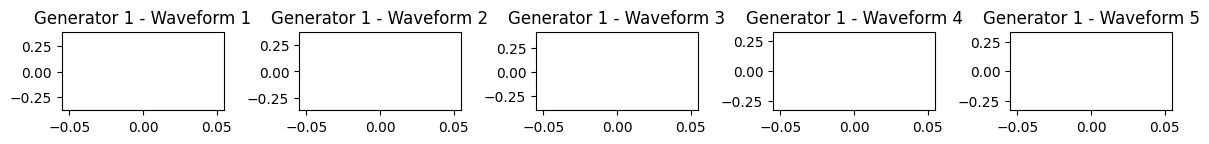

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

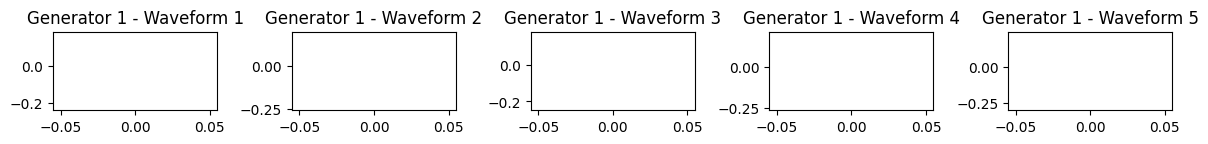

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

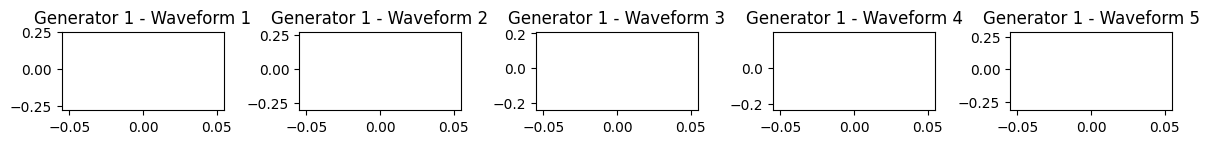

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

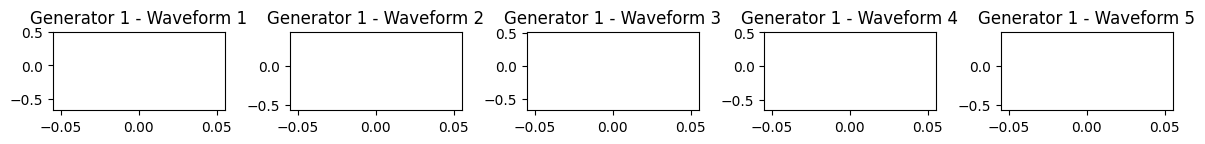

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

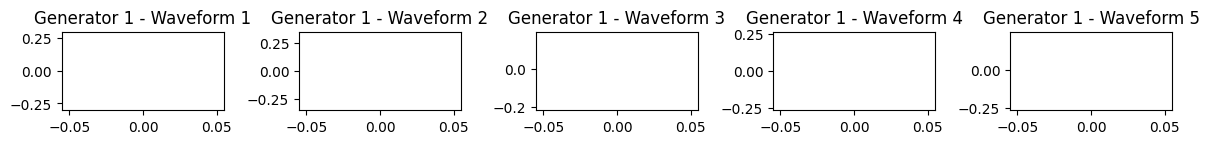

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

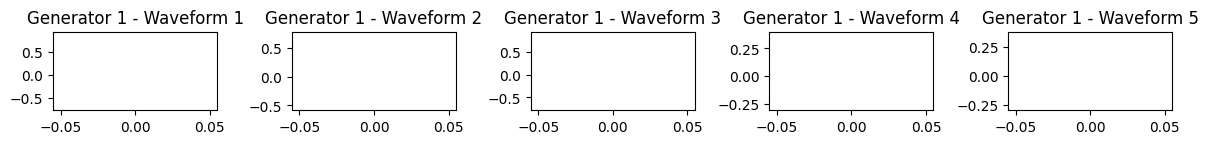

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

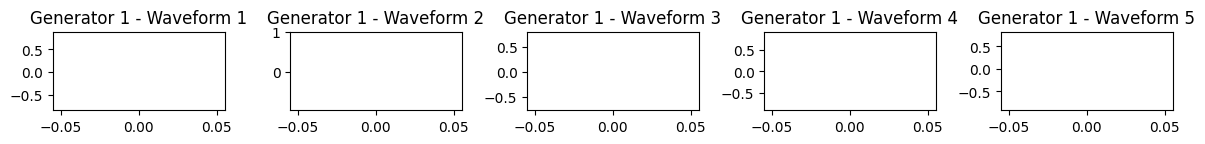

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

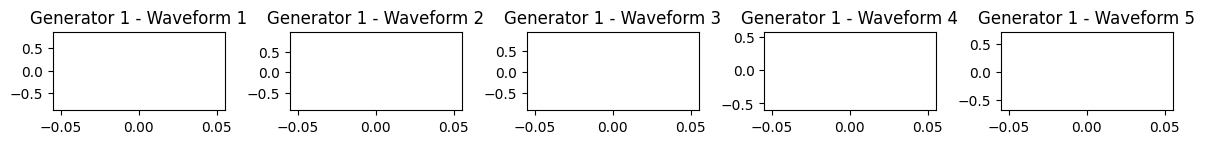

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

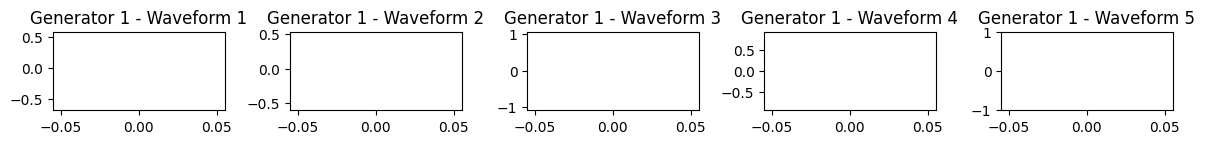

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

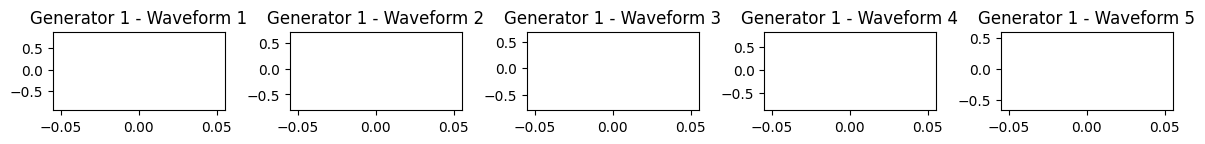

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

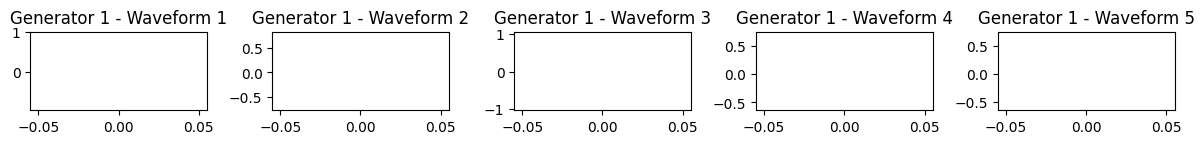

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

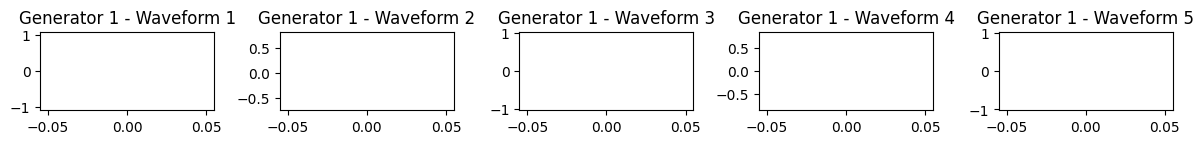

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

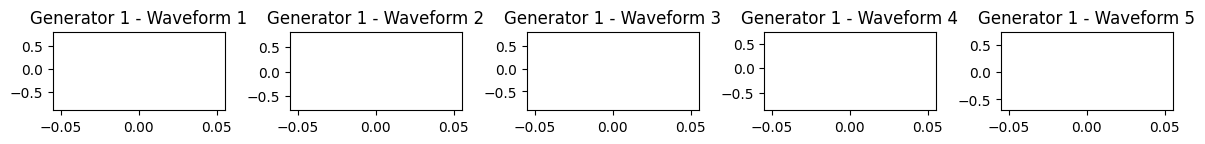

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

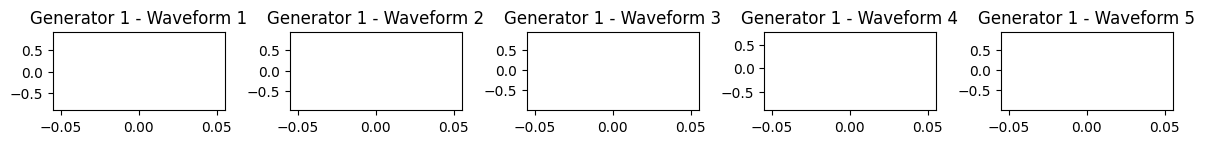

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

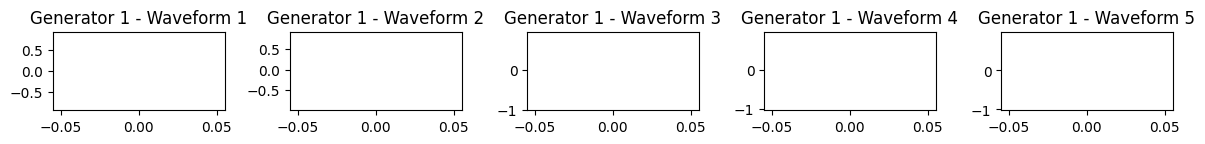

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

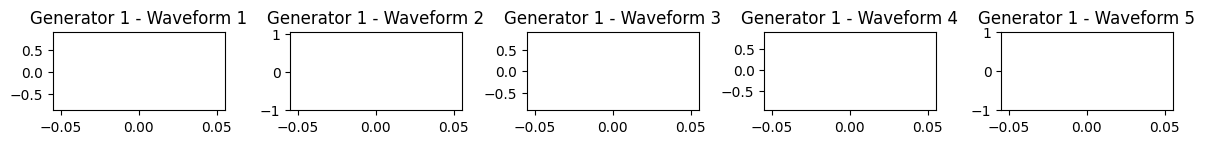

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

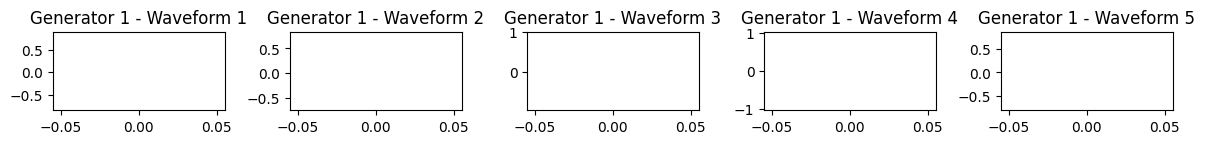

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

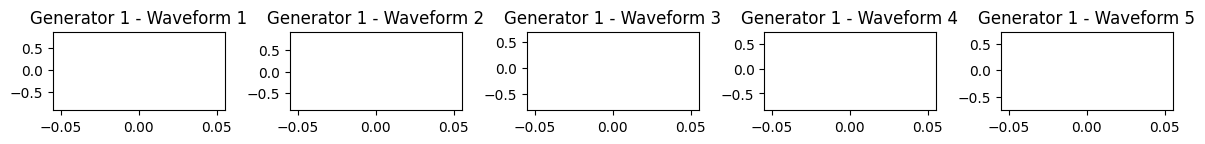

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

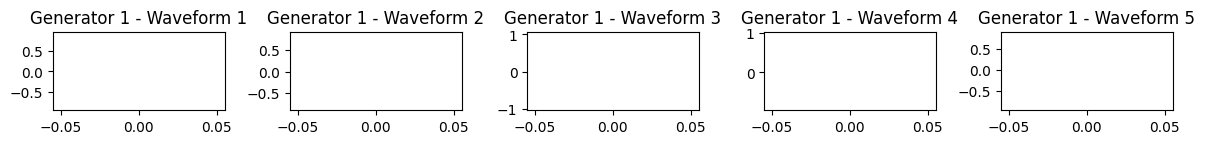

real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([64, 1, 64000])
real shape: torch.Size([6

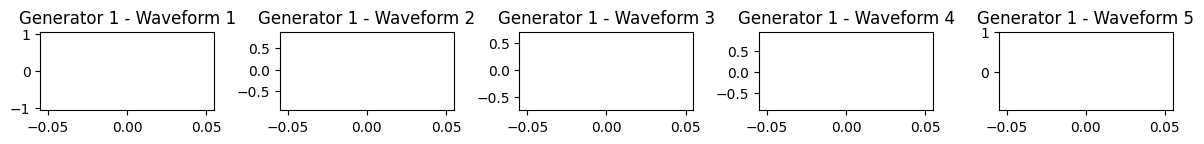

Pretrained generator model saved to waveform_pre/pretrained_generator.pth


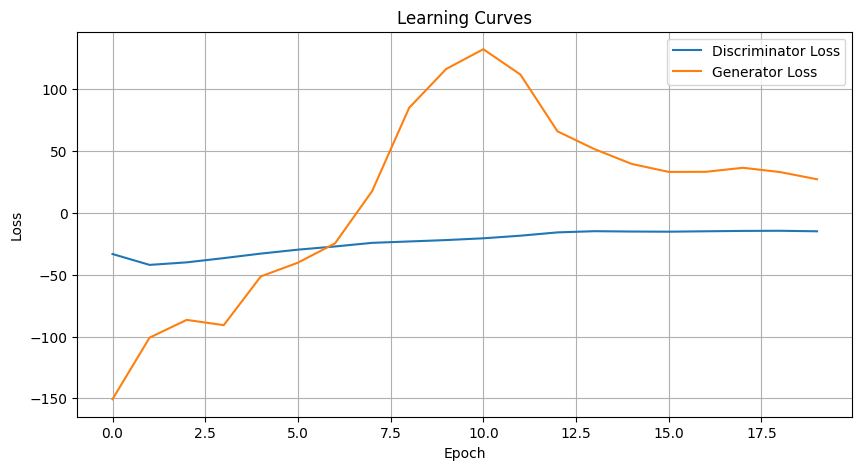

In [14]:
pretrained_generator = pretrain_single_generator(num_epochs=20, 
                                                 z_dim=100, lr_disc=0.0002,lr_gen=0.0002, batch_size=64, seed=42, audio_length=64000, 
                                                 output_dir='waveform_pre', train_dataset=train_dataset)


In [ ]:
import torch

# Clear unused CUDA memory
torch.cuda.empty_cache()


In [ ]:
def load_pretrained_generator(z_dim, weight_path, device, audio_length):
    """
    Load the pretrained generator model weights.

    Args:
        z_dim (int): Latent space dimension.
        weight_path (str): Path to the saved model weights.
        device (torch.device): Device to load the model onto.

    Returns:
        Generator: Loaded generator model.
    """
    generator = Generator(z_dim, audio_length=audio_length).to(device)
    generator.load_state_dict(torch.load(weight_path, map_location=device))
    generator.eval()  # Set the model to evaluation mode
    print(f"Pretrained generator model loaded from {weight_path}")
    return generator


In [ ]:
pretrained_generator = load_pretrained_generator(
    z_dim=100,
    weight_path='waveform_pre/pretrained_generator.pth',  # Path to saved weights
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), audio_length = audio_length
)


Pretrained generator model loaded from waveform_pre/pretrained_generator.pth


/tmp/ipykernel_355308/3981401217.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(weight_path, map_location=device))


Epoch [1/200] Loss D: -4.3990
Loss G1: 16.1318
Loss G2: 15.8636
Loss G3: 16.1076
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch1.wav
Saved waveform_mul/gen1_sample2_epoch1.wav
Saved waveform_mul/gen1_sample3_epoch1.wav
Saved waveform_mul/gen1_sample4_epoch1.wav
Saved waveform_mul/gen1_sample5_epoch1.wav


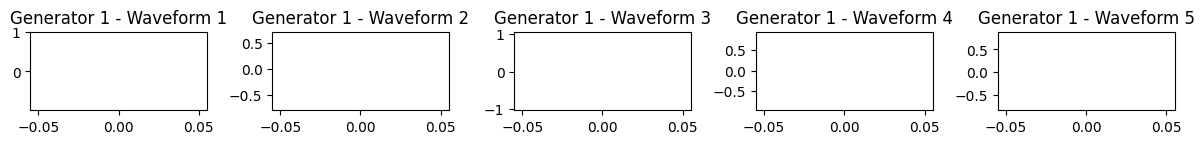

Saved waveform_mul/gen2_sample1_epoch1.wav
Saved waveform_mul/gen2_sample2_epoch1.wav
Saved waveform_mul/gen2_sample3_epoch1.wav
Saved waveform_mul/gen2_sample4_epoch1.wav
Saved waveform_mul/gen2_sample5_epoch1.wav


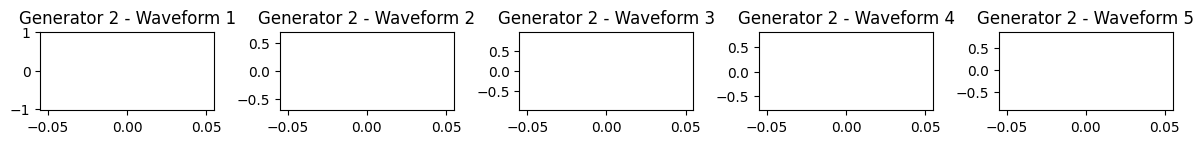

Saved waveform_mul/gen3_sample1_epoch1.wav
Saved waveform_mul/gen3_sample2_epoch1.wav
Saved waveform_mul/gen3_sample3_epoch1.wav
Saved waveform_mul/gen3_sample4_epoch1.wav
Saved waveform_mul/gen3_sample5_epoch1.wav


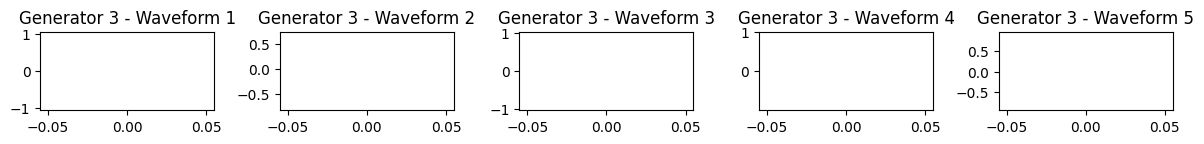

Epoch [2/200] Loss D: -3.9340
Loss G1: 13.1203
Loss G2: 13.1577
Loss G3: 13.3233
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch2.wav
Saved waveform_mul/gen1_sample2_epoch2.wav
Saved waveform_mul/gen1_sample3_epoch2.wav
Saved waveform_mul/gen1_sample4_epoch2.wav
Saved waveform_mul/gen1_sample5_epoch2.wav


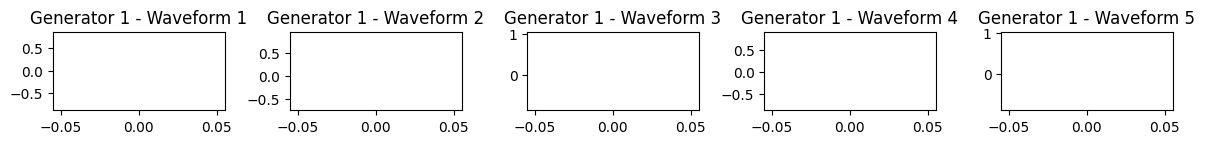

Saved waveform_mul/gen2_sample1_epoch2.wav
Saved waveform_mul/gen2_sample2_epoch2.wav
Saved waveform_mul/gen2_sample3_epoch2.wav
Saved waveform_mul/gen2_sample4_epoch2.wav
Saved waveform_mul/gen2_sample5_epoch2.wav


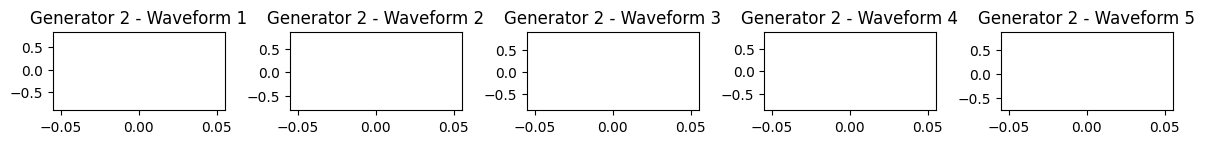

Saved waveform_mul/gen3_sample1_epoch2.wav
Saved waveform_mul/gen3_sample2_epoch2.wav
Saved waveform_mul/gen3_sample3_epoch2.wav
Saved waveform_mul/gen3_sample4_epoch2.wav
Saved waveform_mul/gen3_sample5_epoch2.wav


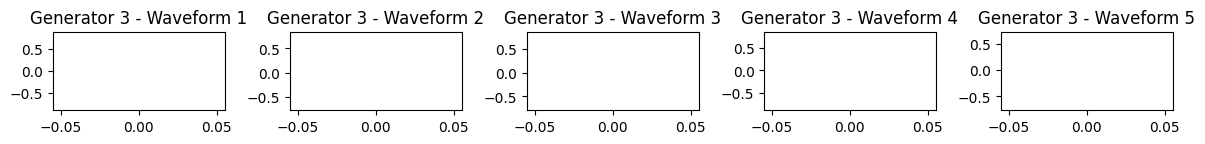

Epoch [3/200] Loss D: -3.8597
Loss G1: 12.7436
Loss G2: 12.9770
Loss G3: 12.6872
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch3.wav
Saved waveform_mul/gen1_sample2_epoch3.wav
Saved waveform_mul/gen1_sample3_epoch3.wav
Saved waveform_mul/gen1_sample4_epoch3.wav
Saved waveform_mul/gen1_sample5_epoch3.wav


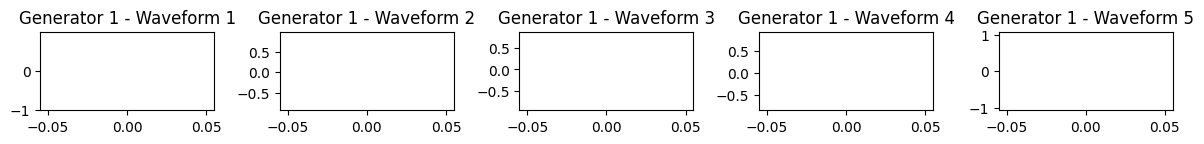

Saved waveform_mul/gen2_sample1_epoch3.wav
Saved waveform_mul/gen2_sample2_epoch3.wav
Saved waveform_mul/gen2_sample3_epoch3.wav
Saved waveform_mul/gen2_sample4_epoch3.wav
Saved waveform_mul/gen2_sample5_epoch3.wav


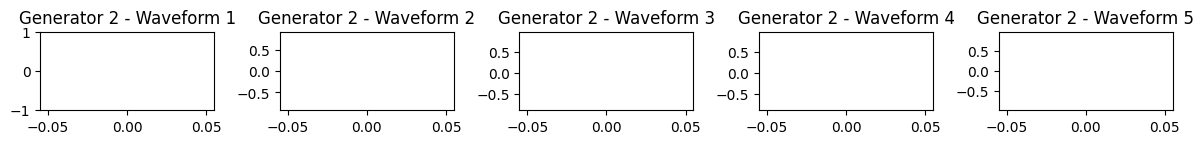

Saved waveform_mul/gen3_sample1_epoch3.wav
Saved waveform_mul/gen3_sample2_epoch3.wav
Saved waveform_mul/gen3_sample3_epoch3.wav
Saved waveform_mul/gen3_sample4_epoch3.wav
Saved waveform_mul/gen3_sample5_epoch3.wav


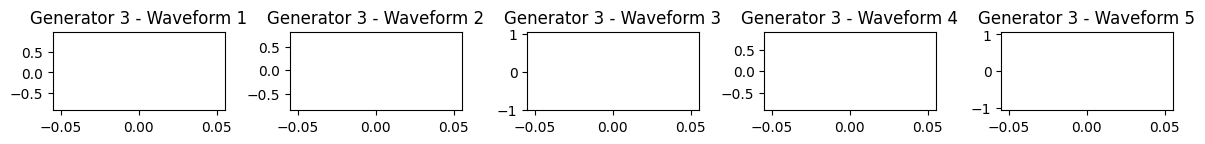

Epoch [4/200] Loss D: -4.3552
Loss G1: -1.8022
Loss G2: -1.8687
Loss G3: -1.6962
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch4.wav
Saved waveform_mul/gen1_sample2_epoch4.wav
Saved waveform_mul/gen1_sample3_epoch4.wav
Saved waveform_mul/gen1_sample4_epoch4.wav
Saved waveform_mul/gen1_sample5_epoch4.wav


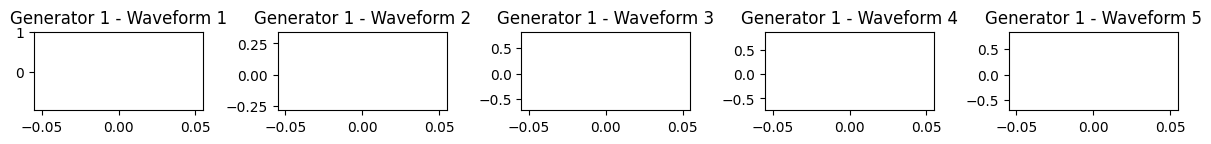

Saved waveform_mul/gen2_sample1_epoch4.wav
Saved waveform_mul/gen2_sample2_epoch4.wav
Saved waveform_mul/gen2_sample3_epoch4.wav
Saved waveform_mul/gen2_sample4_epoch4.wav
Saved waveform_mul/gen2_sample5_epoch4.wav


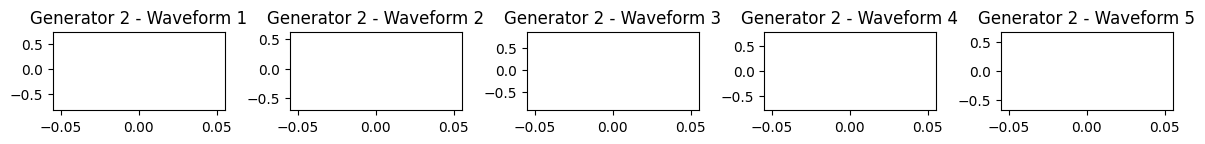

Saved waveform_mul/gen3_sample1_epoch4.wav
Saved waveform_mul/gen3_sample2_epoch4.wav
Saved waveform_mul/gen3_sample3_epoch4.wav
Saved waveform_mul/gen3_sample4_epoch4.wav
Saved waveform_mul/gen3_sample5_epoch4.wav


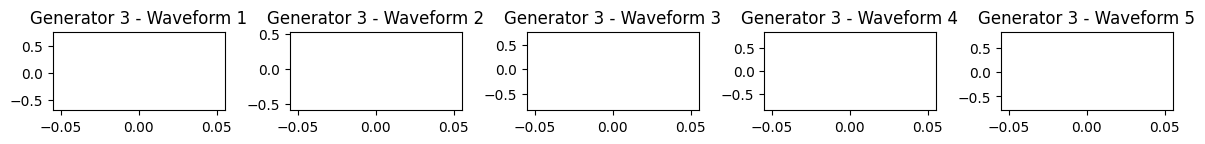

Epoch [5/200] Loss D: -6.1992
Loss G1: -16.3919
Loss G2: -16.7369
Loss G3: -16.5568
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch5.wav
Saved waveform_mul/gen1_sample2_epoch5.wav
Saved waveform_mul/gen1_sample3_epoch5.wav
Saved waveform_mul/gen1_sample4_epoch5.wav
Saved waveform_mul/gen1_sample5_epoch5.wav


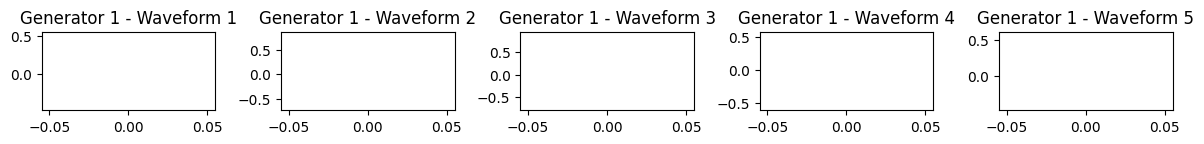

Saved waveform_mul/gen2_sample1_epoch5.wav
Saved waveform_mul/gen2_sample2_epoch5.wav
Saved waveform_mul/gen2_sample3_epoch5.wav
Saved waveform_mul/gen2_sample4_epoch5.wav
Saved waveform_mul/gen2_sample5_epoch5.wav


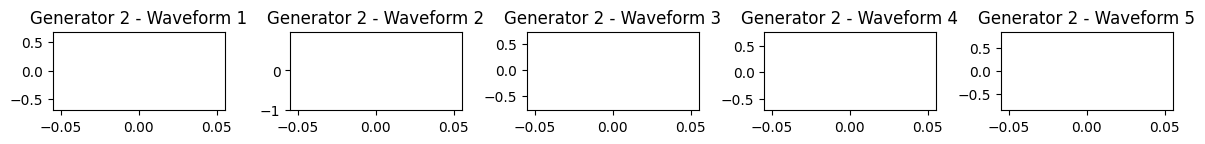

Saved waveform_mul/gen3_sample1_epoch5.wav
Saved waveform_mul/gen3_sample2_epoch5.wav
Saved waveform_mul/gen3_sample3_epoch5.wav
Saved waveform_mul/gen3_sample4_epoch5.wav
Saved waveform_mul/gen3_sample5_epoch5.wav


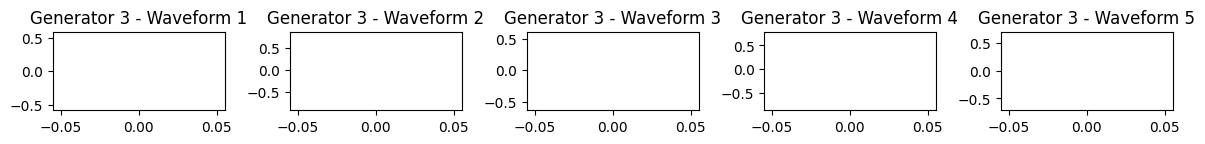

Epoch [6/200] Loss D: -6.9273
Loss G1: -1.1984
Loss G2: -0.4405
Loss G3: -0.9888
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch6.wav
Saved waveform_mul/gen1_sample2_epoch6.wav
Saved waveform_mul/gen1_sample3_epoch6.wav
Saved waveform_mul/gen1_sample4_epoch6.wav
Saved waveform_mul/gen1_sample5_epoch6.wav


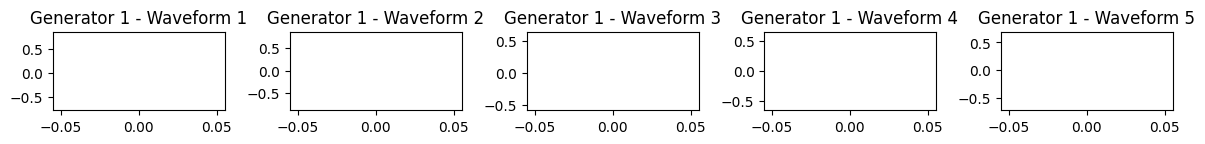

Saved waveform_mul/gen2_sample1_epoch6.wav
Saved waveform_mul/gen2_sample2_epoch6.wav
Saved waveform_mul/gen2_sample3_epoch6.wav
Saved waveform_mul/gen2_sample4_epoch6.wav
Saved waveform_mul/gen2_sample5_epoch6.wav


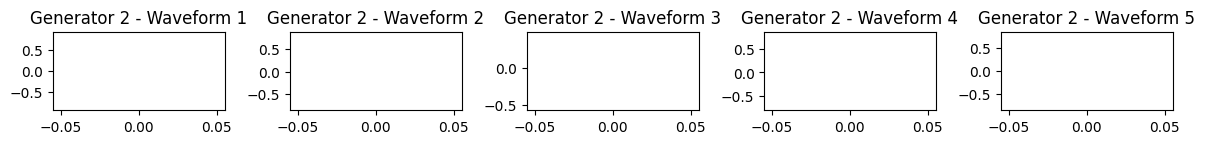

Saved waveform_mul/gen3_sample1_epoch6.wav
Saved waveform_mul/gen3_sample2_epoch6.wav
Saved waveform_mul/gen3_sample3_epoch6.wav
Saved waveform_mul/gen3_sample4_epoch6.wav
Saved waveform_mul/gen3_sample5_epoch6.wav


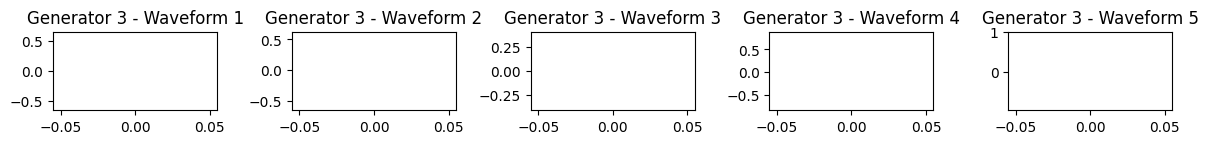

Epoch [7/200] Loss D: -7.4411
Loss G1: 9.6565
Loss G2: 10.4649
Loss G3: 9.9482
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch7.wav
Saved waveform_mul/gen1_sample2_epoch7.wav
Saved waveform_mul/gen1_sample3_epoch7.wav
Saved waveform_mul/gen1_sample4_epoch7.wav
Saved waveform_mul/gen1_sample5_epoch7.wav


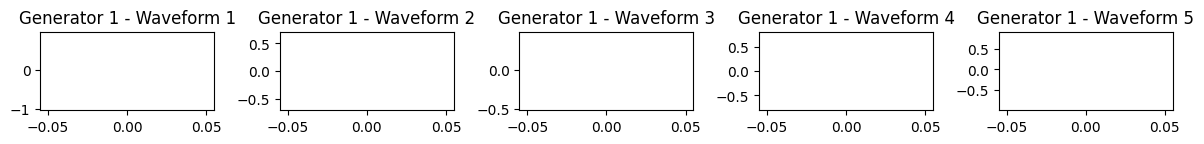

Saved waveform_mul/gen2_sample1_epoch7.wav
Saved waveform_mul/gen2_sample2_epoch7.wav
Saved waveform_mul/gen2_sample3_epoch7.wav
Saved waveform_mul/gen2_sample4_epoch7.wav
Saved waveform_mul/gen2_sample5_epoch7.wav


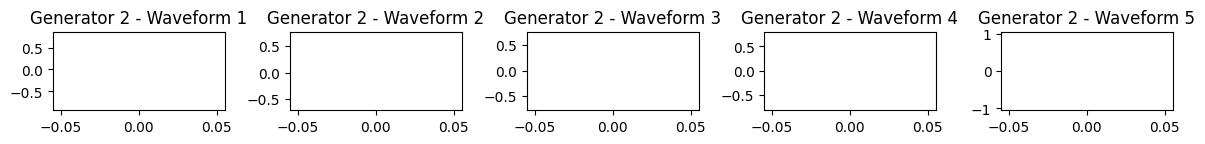

Saved waveform_mul/gen3_sample1_epoch7.wav
Saved waveform_mul/gen3_sample2_epoch7.wav
Saved waveform_mul/gen3_sample3_epoch7.wav
Saved waveform_mul/gen3_sample4_epoch7.wav
Saved waveform_mul/gen3_sample5_epoch7.wav


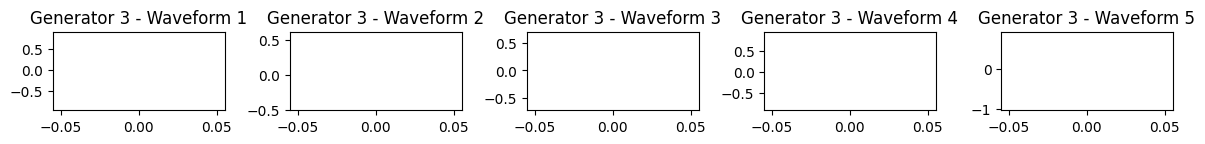

Epoch [8/200] Loss D: -7.6599
Loss G1: 9.0021
Loss G2: 9.5427
Loss G3: 8.8521
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch8.wav
Saved waveform_mul/gen1_sample2_epoch8.wav
Saved waveform_mul/gen1_sample3_epoch8.wav
Saved waveform_mul/gen1_sample4_epoch8.wav
Saved waveform_mul/gen1_sample5_epoch8.wav


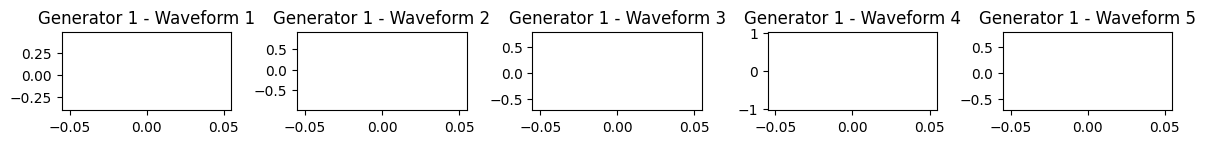

Saved waveform_mul/gen2_sample1_epoch8.wav
Saved waveform_mul/gen2_sample2_epoch8.wav
Saved waveform_mul/gen2_sample3_epoch8.wav
Saved waveform_mul/gen2_sample4_epoch8.wav
Saved waveform_mul/gen2_sample5_epoch8.wav


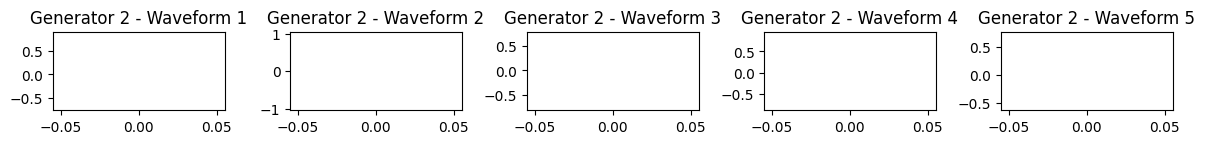

Saved waveform_mul/gen3_sample1_epoch8.wav
Saved waveform_mul/gen3_sample2_epoch8.wav
Saved waveform_mul/gen3_sample3_epoch8.wav
Saved waveform_mul/gen3_sample4_epoch8.wav
Saved waveform_mul/gen3_sample5_epoch8.wav


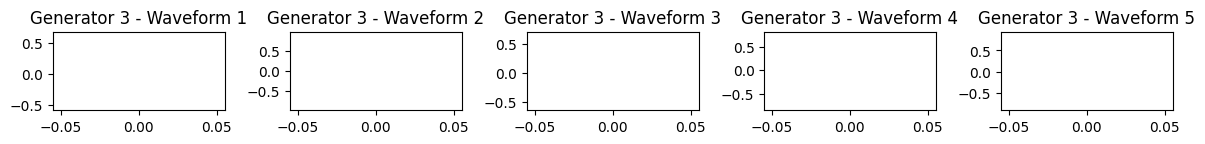

Epoch [9/200] Loss D: -8.2032
Loss G1: 8.1282
Loss G2: 8.4037
Loss G3: 7.8664
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch9.wav
Saved waveform_mul/gen1_sample2_epoch9.wav
Saved waveform_mul/gen1_sample3_epoch9.wav
Saved waveform_mul/gen1_sample4_epoch9.wav
Saved waveform_mul/gen1_sample5_epoch9.wav


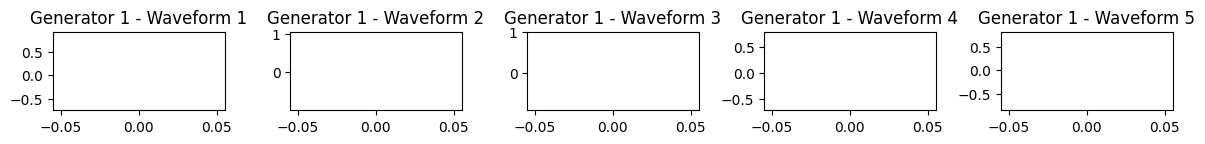

Saved waveform_mul/gen2_sample1_epoch9.wav
Saved waveform_mul/gen2_sample2_epoch9.wav
Saved waveform_mul/gen2_sample3_epoch9.wav
Saved waveform_mul/gen2_sample4_epoch9.wav
Saved waveform_mul/gen2_sample5_epoch9.wav


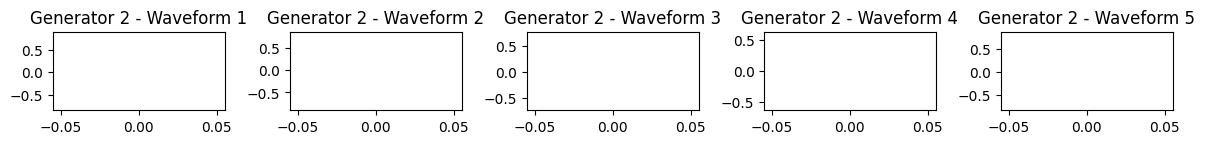

Saved waveform_mul/gen3_sample1_epoch9.wav
Saved waveform_mul/gen3_sample2_epoch9.wav
Saved waveform_mul/gen3_sample3_epoch9.wav
Saved waveform_mul/gen3_sample4_epoch9.wav
Saved waveform_mul/gen3_sample5_epoch9.wav


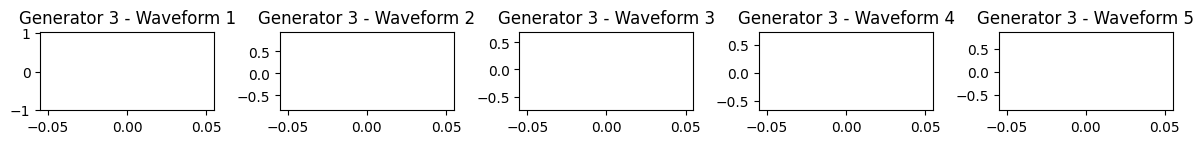

Epoch [10/200] Loss D: -8.3059
Loss G1: 5.4817
Loss G2: 5.5825
Loss G3: 5.2496
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch10.wav
Saved waveform_mul/gen1_sample2_epoch10.wav
Saved waveform_mul/gen1_sample3_epoch10.wav
Saved waveform_mul/gen1_sample4_epoch10.wav
Saved waveform_mul/gen1_sample5_epoch10.wav


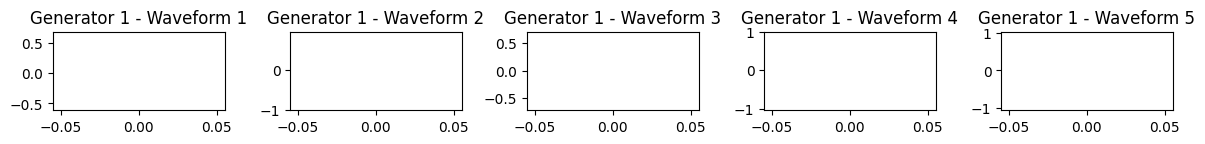

Saved waveform_mul/gen2_sample1_epoch10.wav
Saved waveform_mul/gen2_sample2_epoch10.wav
Saved waveform_mul/gen2_sample3_epoch10.wav
Saved waveform_mul/gen2_sample4_epoch10.wav
Saved waveform_mul/gen2_sample5_epoch10.wav


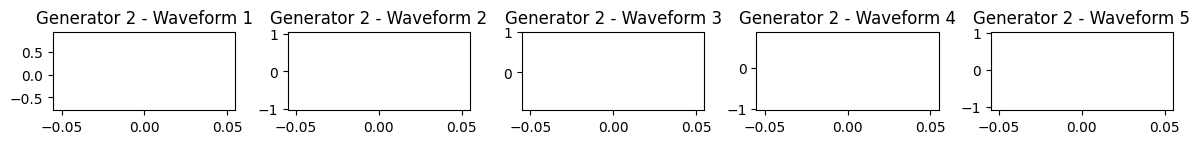

Saved waveform_mul/gen3_sample1_epoch10.wav
Saved waveform_mul/gen3_sample2_epoch10.wav
Saved waveform_mul/gen3_sample3_epoch10.wav
Saved waveform_mul/gen3_sample4_epoch10.wav
Saved waveform_mul/gen3_sample5_epoch10.wav


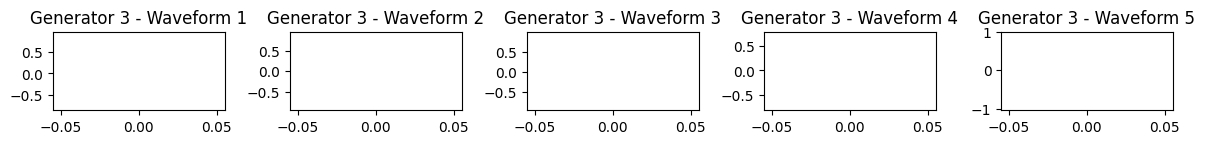

Epoch [11/200] Loss D: -8.0728
Loss G1: 5.7733
Loss G2: 5.9733
Loss G3: 5.4786
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch11.wav
Saved waveform_mul/gen1_sample2_epoch11.wav
Saved waveform_mul/gen1_sample3_epoch11.wav
Saved waveform_mul/gen1_sample4_epoch11.wav
Saved waveform_mul/gen1_sample5_epoch11.wav


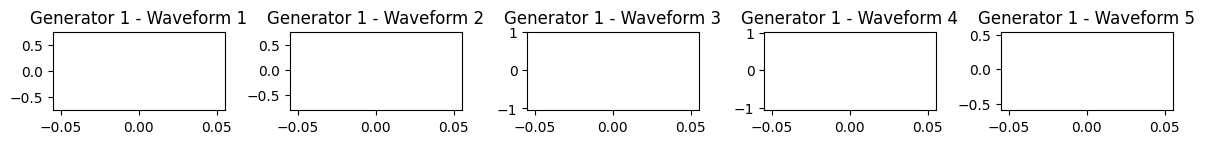

Saved waveform_mul/gen2_sample1_epoch11.wav
Saved waveform_mul/gen2_sample2_epoch11.wav
Saved waveform_mul/gen2_sample3_epoch11.wav
Saved waveform_mul/gen2_sample4_epoch11.wav
Saved waveform_mul/gen2_sample5_epoch11.wav


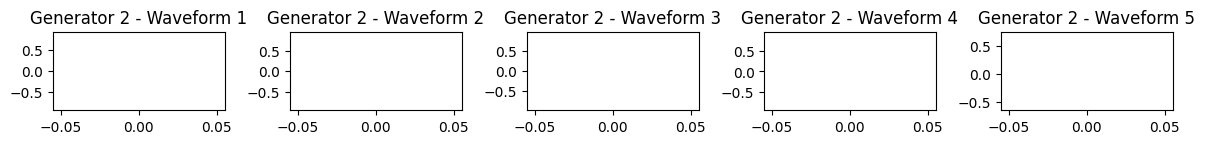

Saved waveform_mul/gen3_sample1_epoch11.wav
Saved waveform_mul/gen3_sample2_epoch11.wav
Saved waveform_mul/gen3_sample3_epoch11.wav
Saved waveform_mul/gen3_sample4_epoch11.wav
Saved waveform_mul/gen3_sample5_epoch11.wav


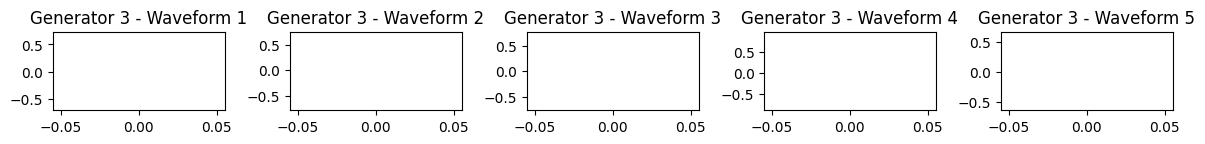

Epoch [12/200] Loss D: -8.4564
Loss G1: 4.8927
Loss G2: 4.8416
Loss G3: 4.5002
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch12.wav
Saved waveform_mul/gen1_sample2_epoch12.wav
Saved waveform_mul/gen1_sample3_epoch12.wav
Saved waveform_mul/gen1_sample4_epoch12.wav
Saved waveform_mul/gen1_sample5_epoch12.wav


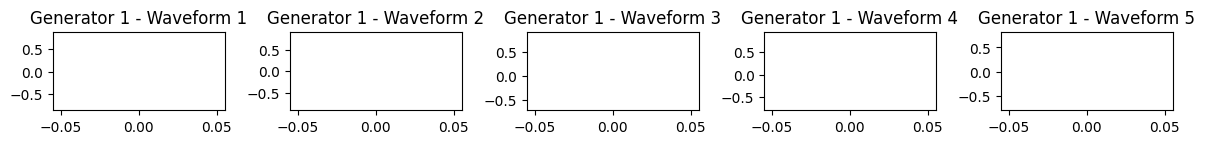

Saved waveform_mul/gen2_sample1_epoch12.wav
Saved waveform_mul/gen2_sample2_epoch12.wav
Saved waveform_mul/gen2_sample3_epoch12.wav
Saved waveform_mul/gen2_sample4_epoch12.wav
Saved waveform_mul/gen2_sample5_epoch12.wav


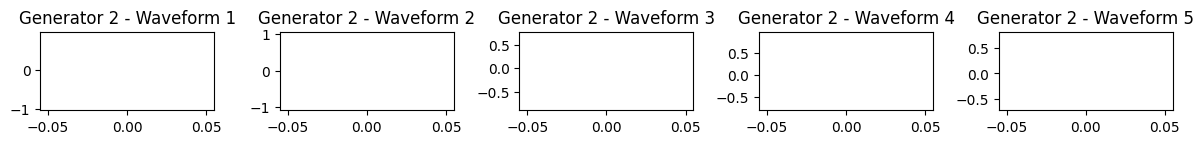

Saved waveform_mul/gen3_sample1_epoch12.wav
Saved waveform_mul/gen3_sample2_epoch12.wav
Saved waveform_mul/gen3_sample3_epoch12.wav
Saved waveform_mul/gen3_sample4_epoch12.wav
Saved waveform_mul/gen3_sample5_epoch12.wav


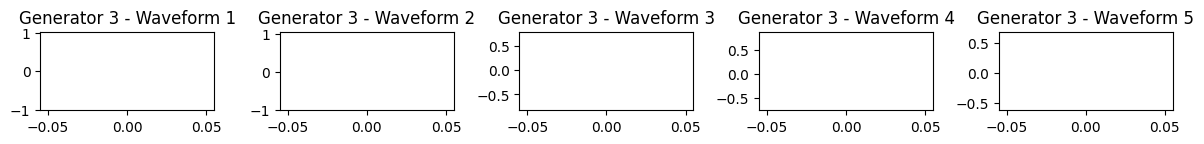

Epoch [13/200] Loss D: -8.4209
Loss G1: 5.9564
Loss G2: 6.2214
Loss G3: 5.8070
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch13.wav
Saved waveform_mul/gen1_sample2_epoch13.wav
Saved waveform_mul/gen1_sample3_epoch13.wav
Saved waveform_mul/gen1_sample4_epoch13.wav
Saved waveform_mul/gen1_sample5_epoch13.wav


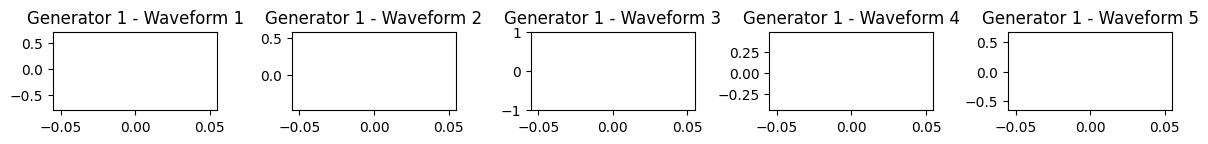

Saved waveform_mul/gen2_sample1_epoch13.wav
Saved waveform_mul/gen2_sample2_epoch13.wav
Saved waveform_mul/gen2_sample3_epoch13.wav
Saved waveform_mul/gen2_sample4_epoch13.wav
Saved waveform_mul/gen2_sample5_epoch13.wav


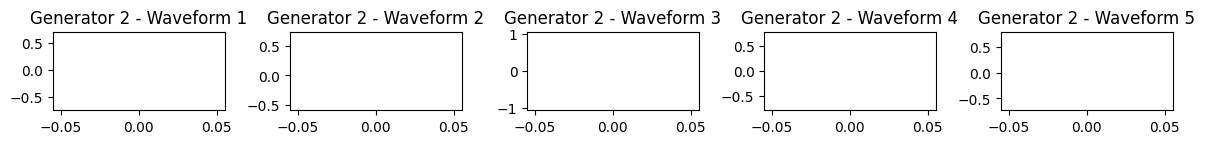

Saved waveform_mul/gen3_sample1_epoch13.wav
Saved waveform_mul/gen3_sample2_epoch13.wav
Saved waveform_mul/gen3_sample3_epoch13.wav
Saved waveform_mul/gen3_sample4_epoch13.wav
Saved waveform_mul/gen3_sample5_epoch13.wav


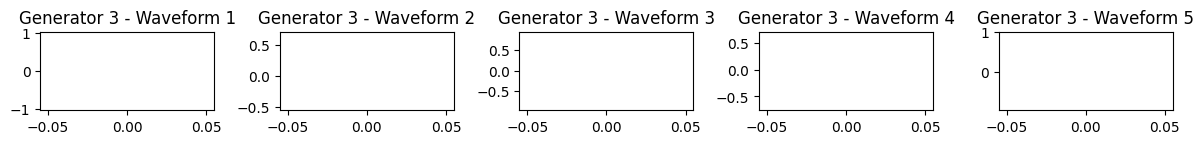

Epoch [14/200] Loss D: -8.3581
Loss G1: 5.6391
Loss G2: 5.4911
Loss G3: 5.2840
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch14.wav
Saved waveform_mul/gen1_sample2_epoch14.wav
Saved waveform_mul/gen1_sample3_epoch14.wav
Saved waveform_mul/gen1_sample4_epoch14.wav
Saved waveform_mul/gen1_sample5_epoch14.wav


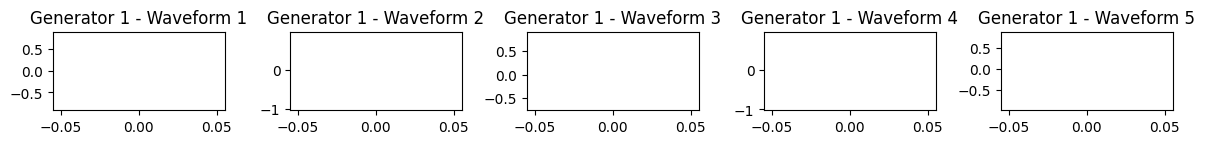

Saved waveform_mul/gen2_sample1_epoch14.wav
Saved waveform_mul/gen2_sample2_epoch14.wav
Saved waveform_mul/gen2_sample3_epoch14.wav
Saved waveform_mul/gen2_sample4_epoch14.wav
Saved waveform_mul/gen2_sample5_epoch14.wav


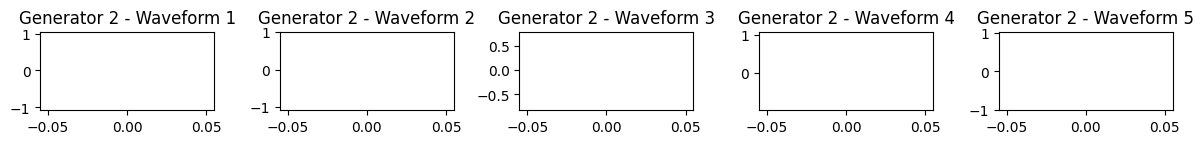

Saved waveform_mul/gen3_sample1_epoch14.wav
Saved waveform_mul/gen3_sample2_epoch14.wav
Saved waveform_mul/gen3_sample3_epoch14.wav
Saved waveform_mul/gen3_sample4_epoch14.wav
Saved waveform_mul/gen3_sample5_epoch14.wav


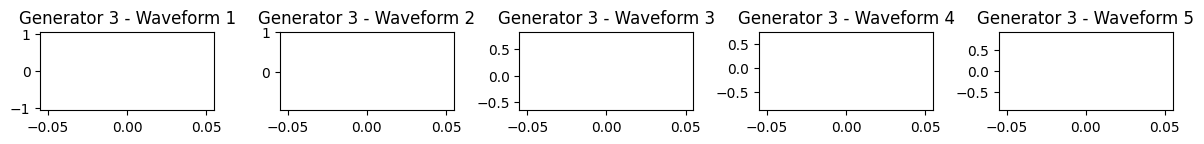

Epoch [15/200] Loss D: -8.0800
Loss G1: 4.5842
Loss G2: 4.7458
Loss G3: 4.5977
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch15.wav
Saved waveform_mul/gen1_sample2_epoch15.wav
Saved waveform_mul/gen1_sample3_epoch15.wav
Saved waveform_mul/gen1_sample4_epoch15.wav
Saved waveform_mul/gen1_sample5_epoch15.wav


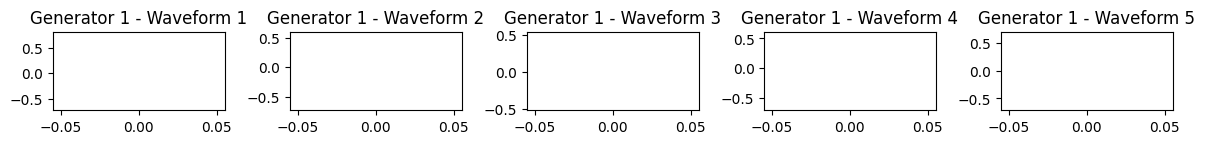

Saved waveform_mul/gen2_sample1_epoch15.wav
Saved waveform_mul/gen2_sample2_epoch15.wav
Saved waveform_mul/gen2_sample3_epoch15.wav
Saved waveform_mul/gen2_sample4_epoch15.wav
Saved waveform_mul/gen2_sample5_epoch15.wav


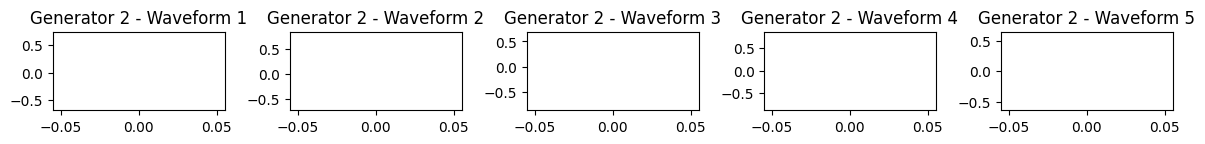

Saved waveform_mul/gen3_sample1_epoch15.wav
Saved waveform_mul/gen3_sample2_epoch15.wav
Saved waveform_mul/gen3_sample3_epoch15.wav
Saved waveform_mul/gen3_sample4_epoch15.wav
Saved waveform_mul/gen3_sample5_epoch15.wav


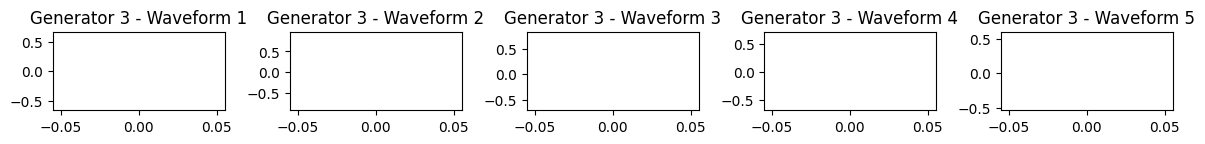

Epoch [16/200] Loss D: -7.9720
Loss G1: 3.7553
Loss G2: 3.7480
Loss G3: 3.5996
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch16.wav
Saved waveform_mul/gen1_sample2_epoch16.wav
Saved waveform_mul/gen1_sample3_epoch16.wav
Saved waveform_mul/gen1_sample4_epoch16.wav
Saved waveform_mul/gen1_sample5_epoch16.wav


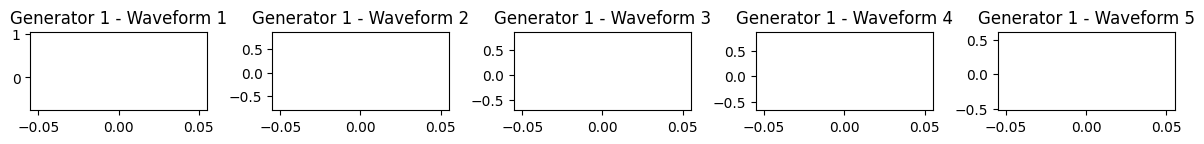

Saved waveform_mul/gen2_sample1_epoch16.wav
Saved waveform_mul/gen2_sample2_epoch16.wav
Saved waveform_mul/gen2_sample3_epoch16.wav
Saved waveform_mul/gen2_sample4_epoch16.wav
Saved waveform_mul/gen2_sample5_epoch16.wav


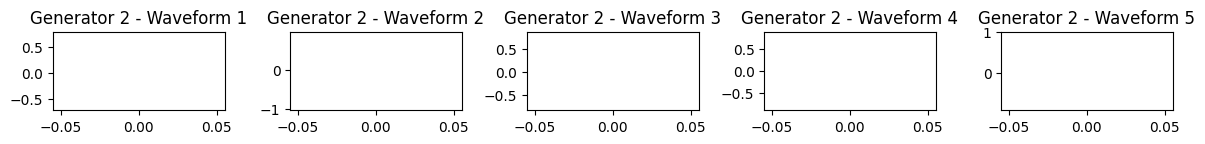

Saved waveform_mul/gen3_sample1_epoch16.wav
Saved waveform_mul/gen3_sample2_epoch16.wav
Saved waveform_mul/gen3_sample3_epoch16.wav
Saved waveform_mul/gen3_sample4_epoch16.wav
Saved waveform_mul/gen3_sample5_epoch16.wav


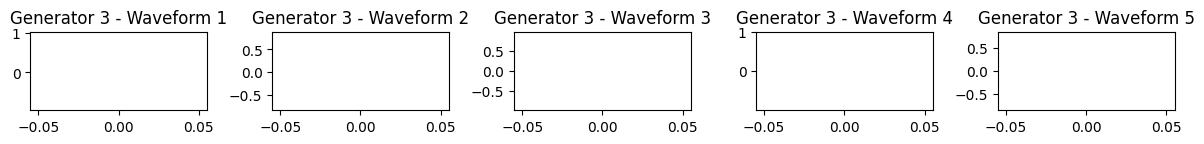

Epoch [17/200] Loss D: -7.6396
Loss G1: 4.9117
Loss G2: 4.9444
Loss G3: 4.9246
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch17.wav
Saved waveform_mul/gen1_sample2_epoch17.wav
Saved waveform_mul/gen1_sample3_epoch17.wav
Saved waveform_mul/gen1_sample4_epoch17.wav
Saved waveform_mul/gen1_sample5_epoch17.wav


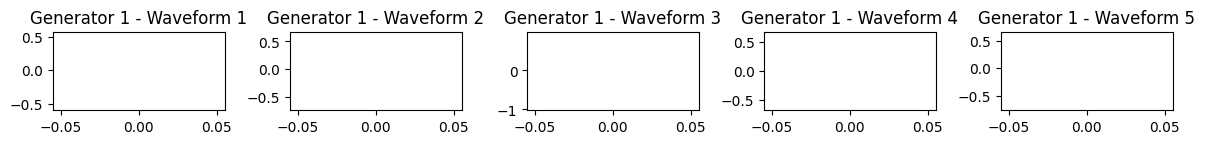

Saved waveform_mul/gen2_sample1_epoch17.wav
Saved waveform_mul/gen2_sample2_epoch17.wav
Saved waveform_mul/gen2_sample3_epoch17.wav
Saved waveform_mul/gen2_sample4_epoch17.wav
Saved waveform_mul/gen2_sample5_epoch17.wav


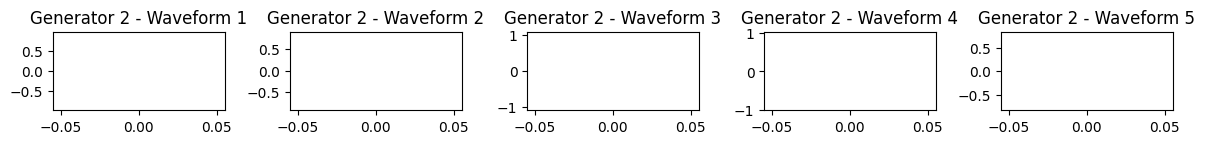

Saved waveform_mul/gen3_sample1_epoch17.wav
Saved waveform_mul/gen3_sample2_epoch17.wav
Saved waveform_mul/gen3_sample3_epoch17.wav
Saved waveform_mul/gen3_sample4_epoch17.wav
Saved waveform_mul/gen3_sample5_epoch17.wav


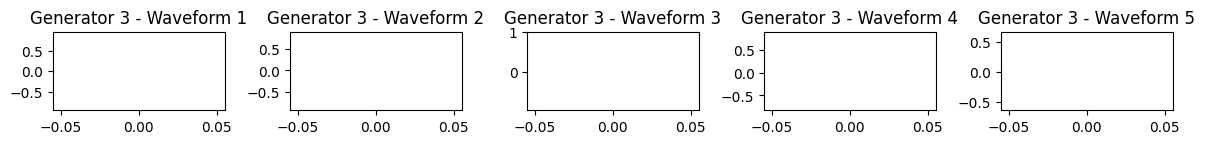

Epoch [18/200] Loss D: -7.4883
Loss G1: 4.9975
Loss G2: 5.2137
Loss G3: 5.0787
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch18.wav
Saved waveform_mul/gen1_sample2_epoch18.wav
Saved waveform_mul/gen1_sample3_epoch18.wav
Saved waveform_mul/gen1_sample4_epoch18.wav
Saved waveform_mul/gen1_sample5_epoch18.wav


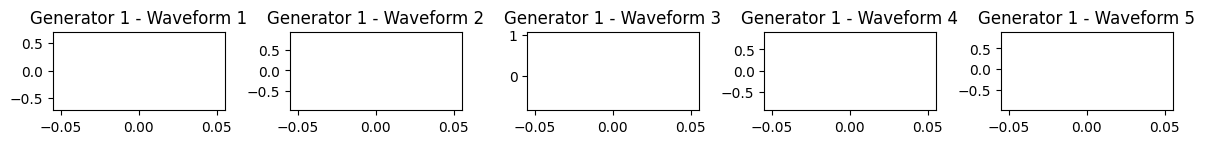

Saved waveform_mul/gen2_sample1_epoch18.wav
Saved waveform_mul/gen2_sample2_epoch18.wav
Saved waveform_mul/gen2_sample3_epoch18.wav
Saved waveform_mul/gen2_sample4_epoch18.wav
Saved waveform_mul/gen2_sample5_epoch18.wav


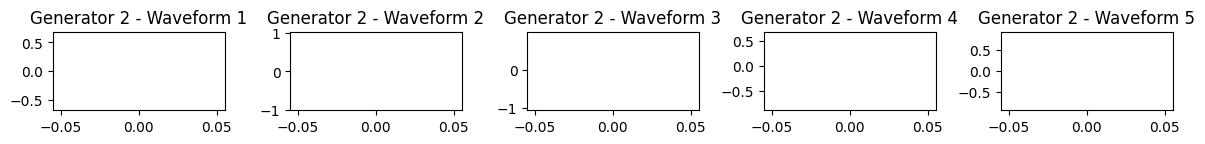

Saved waveform_mul/gen3_sample1_epoch18.wav
Saved waveform_mul/gen3_sample2_epoch18.wav
Saved waveform_mul/gen3_sample3_epoch18.wav
Saved waveform_mul/gen3_sample4_epoch18.wav
Saved waveform_mul/gen3_sample5_epoch18.wav


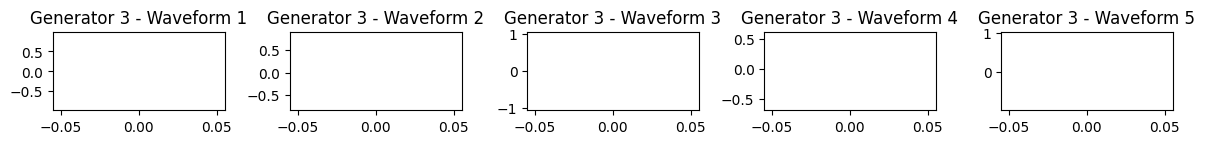

Epoch [19/200] Loss D: -7.2030
Loss G1: 4.6645
Loss G2: 4.7569
Loss G3: 4.7488
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch19.wav
Saved waveform_mul/gen1_sample2_epoch19.wav
Saved waveform_mul/gen1_sample3_epoch19.wav
Saved waveform_mul/gen1_sample4_epoch19.wav
Saved waveform_mul/gen1_sample5_epoch19.wav


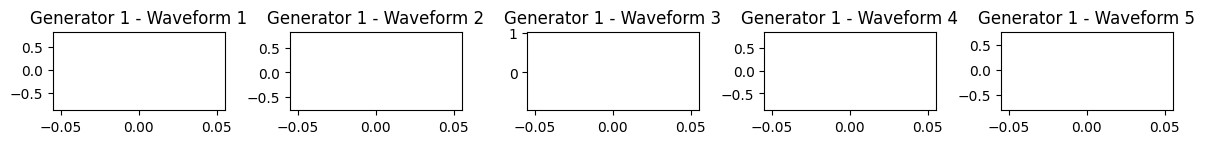

Saved waveform_mul/gen2_sample1_epoch19.wav
Saved waveform_mul/gen2_sample2_epoch19.wav
Saved waveform_mul/gen2_sample3_epoch19.wav
Saved waveform_mul/gen2_sample4_epoch19.wav
Saved waveform_mul/gen2_sample5_epoch19.wav


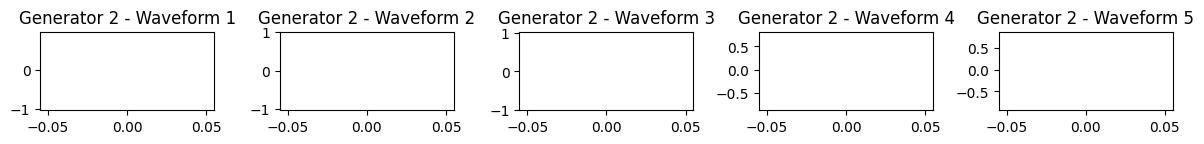

Saved waveform_mul/gen3_sample1_epoch19.wav
Saved waveform_mul/gen3_sample2_epoch19.wav
Saved waveform_mul/gen3_sample3_epoch19.wav
Saved waveform_mul/gen3_sample4_epoch19.wav
Saved waveform_mul/gen3_sample5_epoch19.wav


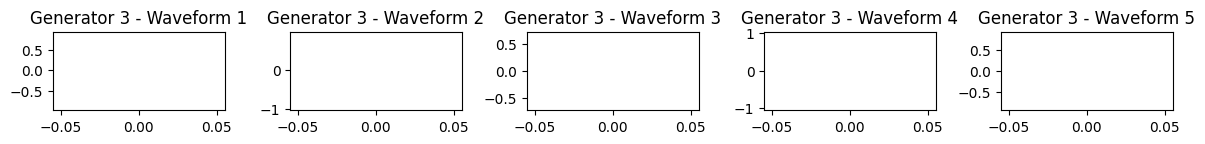

Epoch [20/200] Loss D: -7.1700
Loss G1: 4.6989
Loss G2: 5.0078
Loss G3: 4.7198
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch20.wav
Saved waveform_mul/gen1_sample2_epoch20.wav
Saved waveform_mul/gen1_sample3_epoch20.wav
Saved waveform_mul/gen1_sample4_epoch20.wav
Saved waveform_mul/gen1_sample5_epoch20.wav


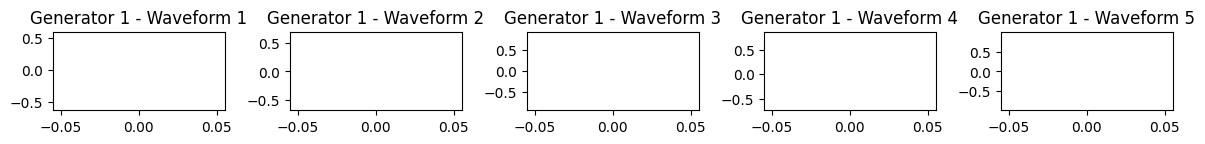

Saved waveform_mul/gen2_sample1_epoch20.wav
Saved waveform_mul/gen2_sample2_epoch20.wav
Saved waveform_mul/gen2_sample3_epoch20.wav
Saved waveform_mul/gen2_sample4_epoch20.wav
Saved waveform_mul/gen2_sample5_epoch20.wav


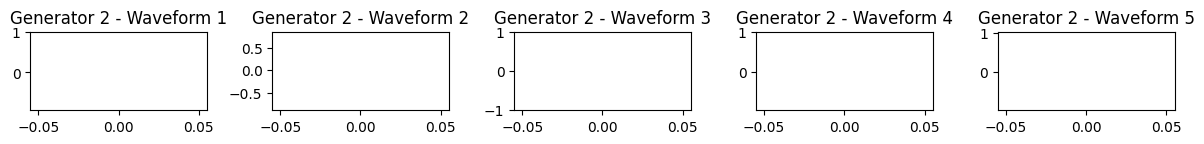

Saved waveform_mul/gen3_sample1_epoch20.wav
Saved waveform_mul/gen3_sample2_epoch20.wav
Saved waveform_mul/gen3_sample3_epoch20.wav
Saved waveform_mul/gen3_sample4_epoch20.wav
Saved waveform_mul/gen3_sample5_epoch20.wav


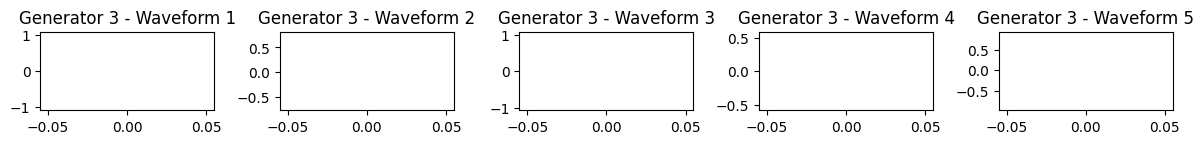

Epoch [21/200] Loss D: -7.0124
Loss G1: 4.9643
Loss G2: 5.3193
Loss G3: 5.1834
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch21.wav
Saved waveform_mul/gen1_sample2_epoch21.wav
Saved waveform_mul/gen1_sample3_epoch21.wav
Saved waveform_mul/gen1_sample4_epoch21.wav
Saved waveform_mul/gen1_sample5_epoch21.wav


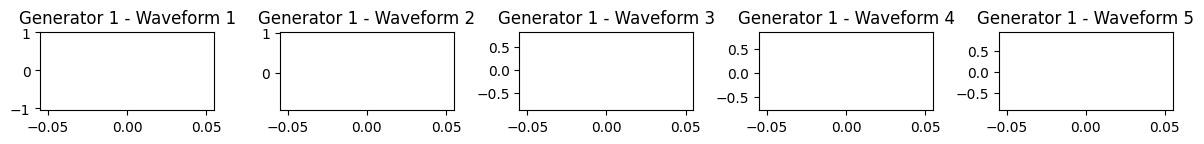

Saved waveform_mul/gen2_sample1_epoch21.wav
Saved waveform_mul/gen2_sample2_epoch21.wav
Saved waveform_mul/gen2_sample3_epoch21.wav
Saved waveform_mul/gen2_sample4_epoch21.wav
Saved waveform_mul/gen2_sample5_epoch21.wav


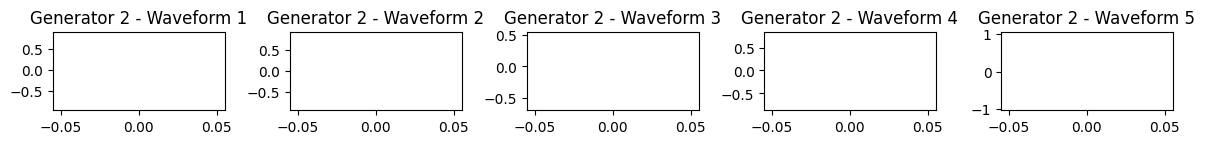

Saved waveform_mul/gen3_sample1_epoch21.wav
Saved waveform_mul/gen3_sample2_epoch21.wav
Saved waveform_mul/gen3_sample3_epoch21.wav
Saved waveform_mul/gen3_sample4_epoch21.wav
Saved waveform_mul/gen3_sample5_epoch21.wav


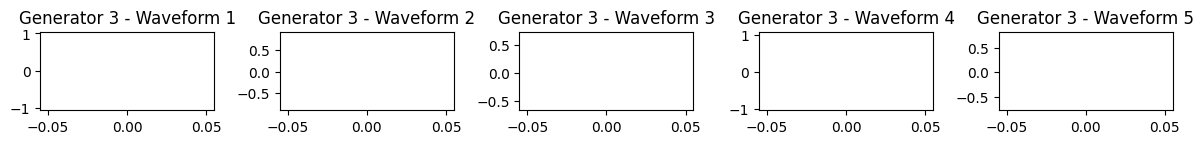

Epoch [22/200] Loss D: -6.8413
Loss G1: 4.6217
Loss G2: 4.9428
Loss G3: 4.6682
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch22.wav
Saved waveform_mul/gen1_sample2_epoch22.wav
Saved waveform_mul/gen1_sample3_epoch22.wav
Saved waveform_mul/gen1_sample4_epoch22.wav
Saved waveform_mul/gen1_sample5_epoch22.wav


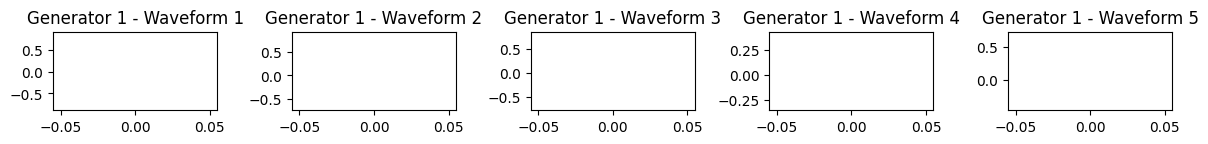

Saved waveform_mul/gen2_sample1_epoch22.wav
Saved waveform_mul/gen2_sample2_epoch22.wav
Saved waveform_mul/gen2_sample3_epoch22.wav
Saved waveform_mul/gen2_sample4_epoch22.wav
Saved waveform_mul/gen2_sample5_epoch22.wav


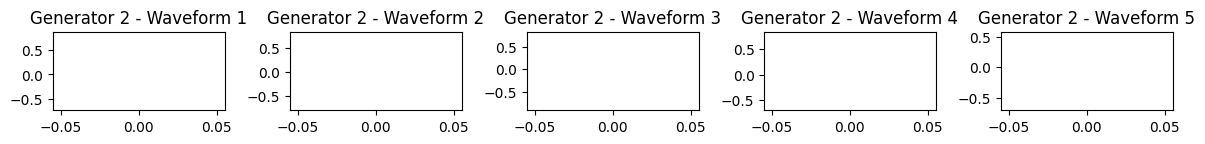

Saved waveform_mul/gen3_sample1_epoch22.wav
Saved waveform_mul/gen3_sample2_epoch22.wav
Saved waveform_mul/gen3_sample3_epoch22.wav
Saved waveform_mul/gen3_sample4_epoch22.wav
Saved waveform_mul/gen3_sample5_epoch22.wav


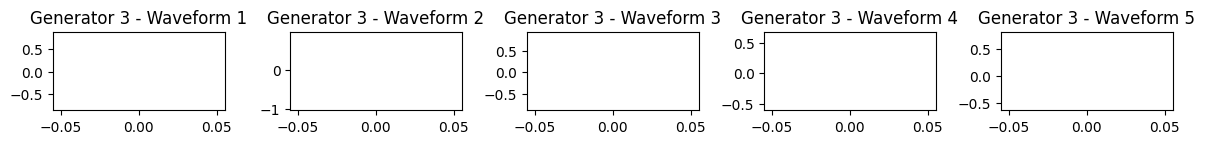

Epoch [23/200] Loss D: -6.8016
Loss G1: 5.0888
Loss G2: 5.4662
Loss G3: 5.1152
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch23.wav
Saved waveform_mul/gen1_sample2_epoch23.wav
Saved waveform_mul/gen1_sample3_epoch23.wav
Saved waveform_mul/gen1_sample4_epoch23.wav
Saved waveform_mul/gen1_sample5_epoch23.wav


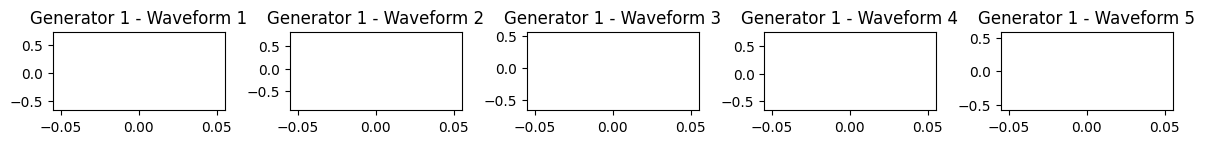

Saved waveform_mul/gen2_sample1_epoch23.wav
Saved waveform_mul/gen2_sample2_epoch23.wav
Saved waveform_mul/gen2_sample3_epoch23.wav
Saved waveform_mul/gen2_sample4_epoch23.wav
Saved waveform_mul/gen2_sample5_epoch23.wav


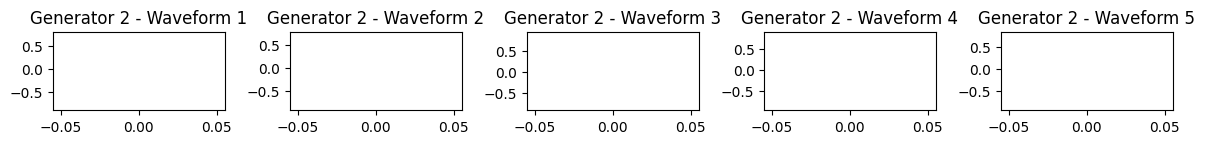

Saved waveform_mul/gen3_sample1_epoch23.wav
Saved waveform_mul/gen3_sample2_epoch23.wav
Saved waveform_mul/gen3_sample3_epoch23.wav
Saved waveform_mul/gen3_sample4_epoch23.wav
Saved waveform_mul/gen3_sample5_epoch23.wav


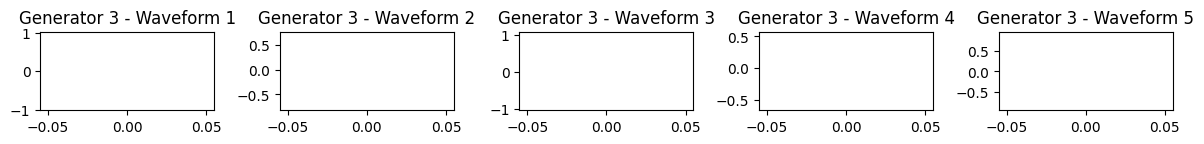

Epoch [24/200] Loss D: -6.8517
Loss G1: 5.4247
Loss G2: 5.3257
Loss G3: 5.4185
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch24.wav
Saved waveform_mul/gen1_sample2_epoch24.wav
Saved waveform_mul/gen1_sample3_epoch24.wav
Saved waveform_mul/gen1_sample4_epoch24.wav
Saved waveform_mul/gen1_sample5_epoch24.wav


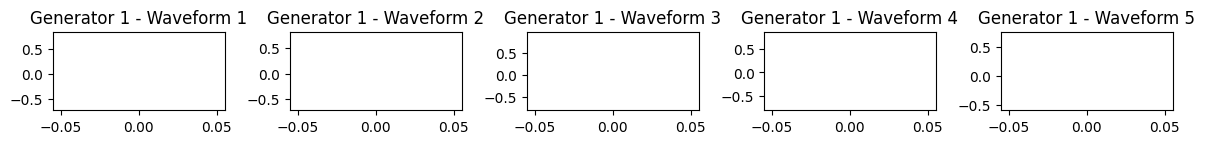

Saved waveform_mul/gen2_sample1_epoch24.wav
Saved waveform_mul/gen2_sample2_epoch24.wav
Saved waveform_mul/gen2_sample3_epoch24.wav
Saved waveform_mul/gen2_sample4_epoch24.wav
Saved waveform_mul/gen2_sample5_epoch24.wav


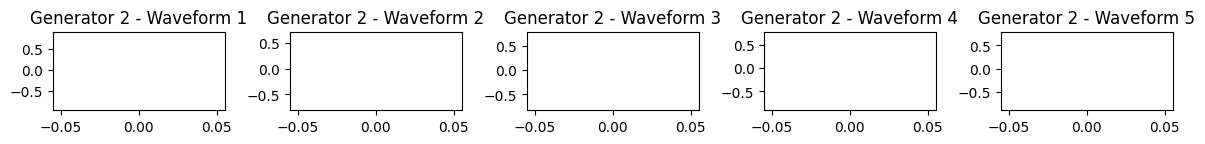

Saved waveform_mul/gen3_sample1_epoch24.wav
Saved waveform_mul/gen3_sample2_epoch24.wav
Saved waveform_mul/gen3_sample3_epoch24.wav
Saved waveform_mul/gen3_sample4_epoch24.wav
Saved waveform_mul/gen3_sample5_epoch24.wav


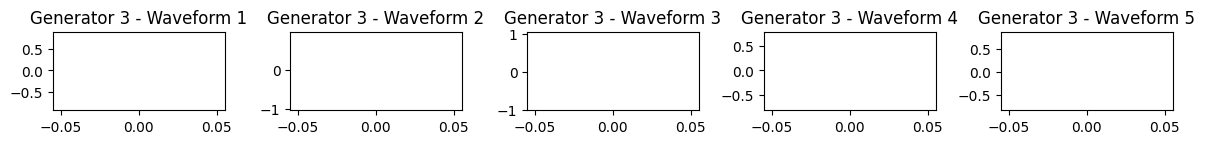

Epoch [25/200] Loss D: -6.7627
Loss G1: 5.3253
Loss G2: 5.6782
Loss G3: 5.5024
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch25.wav
Saved waveform_mul/gen1_sample2_epoch25.wav
Saved waveform_mul/gen1_sample3_epoch25.wav
Saved waveform_mul/gen1_sample4_epoch25.wav
Saved waveform_mul/gen1_sample5_epoch25.wav


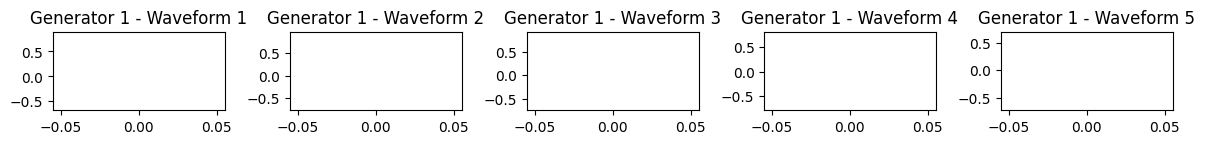

Saved waveform_mul/gen2_sample1_epoch25.wav
Saved waveform_mul/gen2_sample2_epoch25.wav
Saved waveform_mul/gen2_sample3_epoch25.wav
Saved waveform_mul/gen2_sample4_epoch25.wav
Saved waveform_mul/gen2_sample5_epoch25.wav


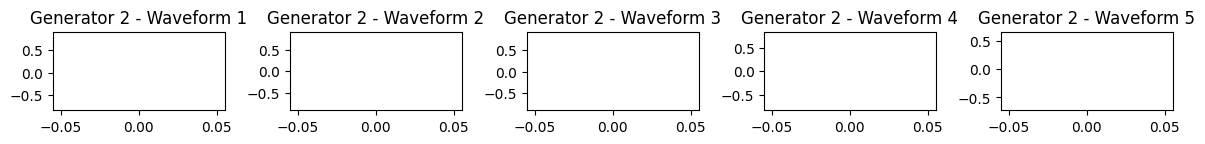

Saved waveform_mul/gen3_sample1_epoch25.wav
Saved waveform_mul/gen3_sample2_epoch25.wav
Saved waveform_mul/gen3_sample3_epoch25.wav
Saved waveform_mul/gen3_sample4_epoch25.wav
Saved waveform_mul/gen3_sample5_epoch25.wav


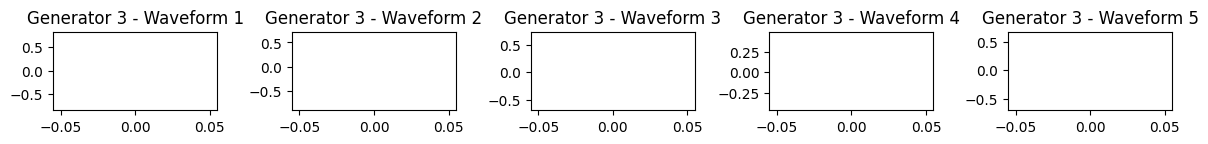

Epoch [26/200] Loss D: -6.4952
Loss G1: 4.7860
Loss G2: 5.1077
Loss G3: 4.9893
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch26.wav
Saved waveform_mul/gen1_sample2_epoch26.wav
Saved waveform_mul/gen1_sample3_epoch26.wav
Saved waveform_mul/gen1_sample4_epoch26.wav
Saved waveform_mul/gen1_sample5_epoch26.wav


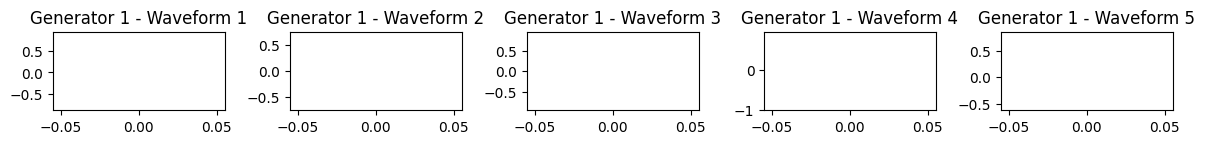

Saved waveform_mul/gen2_sample1_epoch26.wav
Saved waveform_mul/gen2_sample2_epoch26.wav
Saved waveform_mul/gen2_sample3_epoch26.wav
Saved waveform_mul/gen2_sample4_epoch26.wav
Saved waveform_mul/gen2_sample5_epoch26.wav


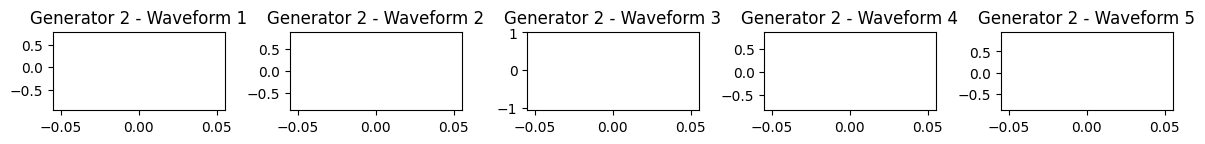

Saved waveform_mul/gen3_sample1_epoch26.wav
Saved waveform_mul/gen3_sample2_epoch26.wav
Saved waveform_mul/gen3_sample3_epoch26.wav
Saved waveform_mul/gen3_sample4_epoch26.wav
Saved waveform_mul/gen3_sample5_epoch26.wav


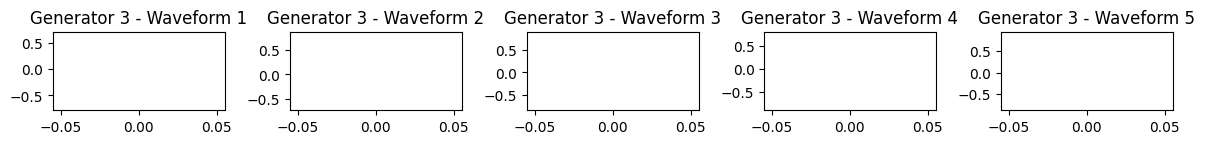

Epoch [27/200] Loss D: -6.5660
Loss G1: 5.7853
Loss G2: 5.8570
Loss G3: 5.8050
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch27.wav
Saved waveform_mul/gen1_sample2_epoch27.wav
Saved waveform_mul/gen1_sample3_epoch27.wav
Saved waveform_mul/gen1_sample4_epoch27.wav
Saved waveform_mul/gen1_sample5_epoch27.wav


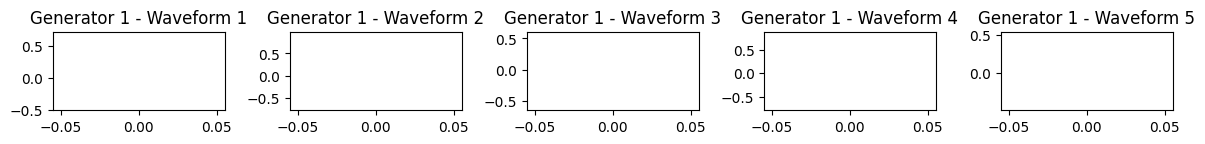

Saved waveform_mul/gen2_sample1_epoch27.wav
Saved waveform_mul/gen2_sample2_epoch27.wav
Saved waveform_mul/gen2_sample3_epoch27.wav
Saved waveform_mul/gen2_sample4_epoch27.wav
Saved waveform_mul/gen2_sample5_epoch27.wav


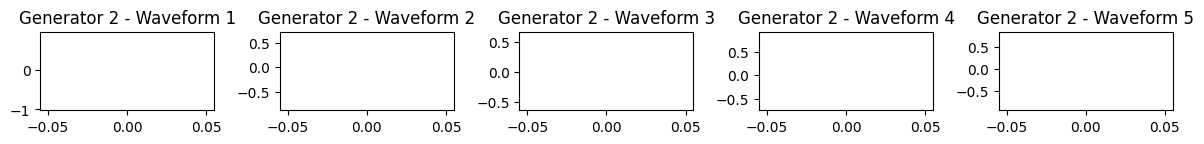

Saved waveform_mul/gen3_sample1_epoch27.wav
Saved waveform_mul/gen3_sample2_epoch27.wav
Saved waveform_mul/gen3_sample3_epoch27.wav
Saved waveform_mul/gen3_sample4_epoch27.wav
Saved waveform_mul/gen3_sample5_epoch27.wav


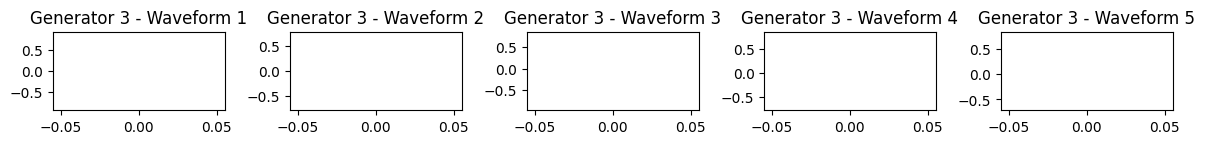

Epoch [28/200] Loss D: -6.5178
Loss G1: 4.9844
Loss G2: 5.2898
Loss G3: 4.9260
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch28.wav
Saved waveform_mul/gen1_sample2_epoch28.wav
Saved waveform_mul/gen1_sample3_epoch28.wav
Saved waveform_mul/gen1_sample4_epoch28.wav
Saved waveform_mul/gen1_sample5_epoch28.wav


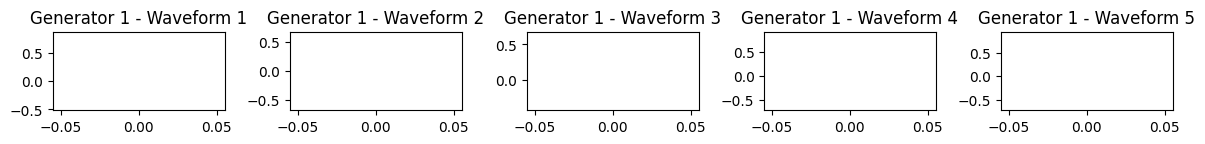

Saved waveform_mul/gen2_sample1_epoch28.wav
Saved waveform_mul/gen2_sample2_epoch28.wav
Saved waveform_mul/gen2_sample3_epoch28.wav
Saved waveform_mul/gen2_sample4_epoch28.wav
Saved waveform_mul/gen2_sample5_epoch28.wav


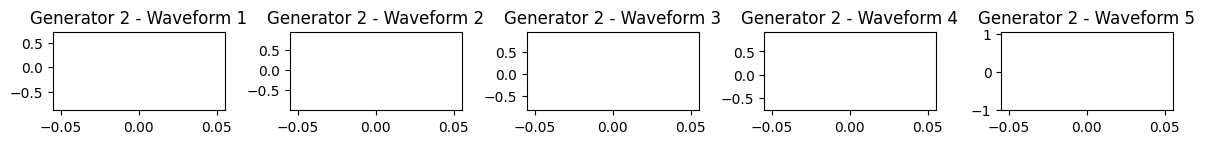

Saved waveform_mul/gen3_sample1_epoch28.wav
Saved waveform_mul/gen3_sample2_epoch28.wav
Saved waveform_mul/gen3_sample3_epoch28.wav
Saved waveform_mul/gen3_sample4_epoch28.wav
Saved waveform_mul/gen3_sample5_epoch28.wav


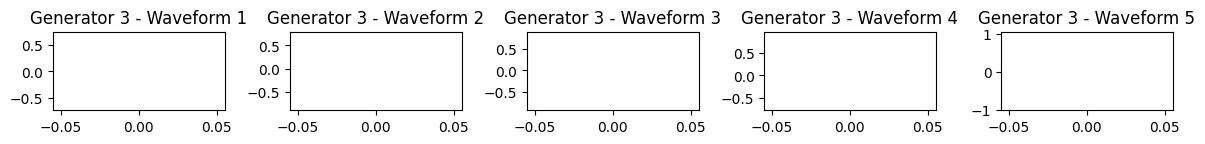

Epoch [29/200] Loss D: -6.3937
Loss G1: 5.6735
Loss G2: 5.9396
Loss G3: 5.8279
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch29.wav
Saved waveform_mul/gen1_sample2_epoch29.wav
Saved waveform_mul/gen1_sample3_epoch29.wav
Saved waveform_mul/gen1_sample4_epoch29.wav
Saved waveform_mul/gen1_sample5_epoch29.wav


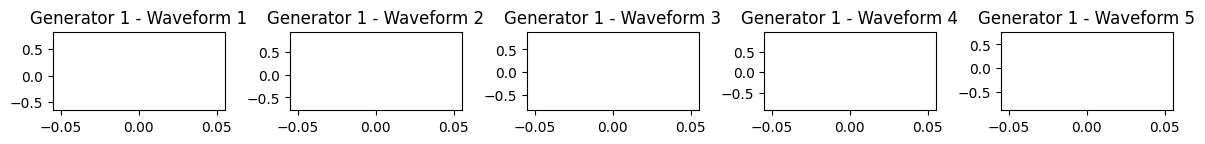

Saved waveform_mul/gen2_sample1_epoch29.wav
Saved waveform_mul/gen2_sample2_epoch29.wav
Saved waveform_mul/gen2_sample3_epoch29.wav
Saved waveform_mul/gen2_sample4_epoch29.wav
Saved waveform_mul/gen2_sample5_epoch29.wav


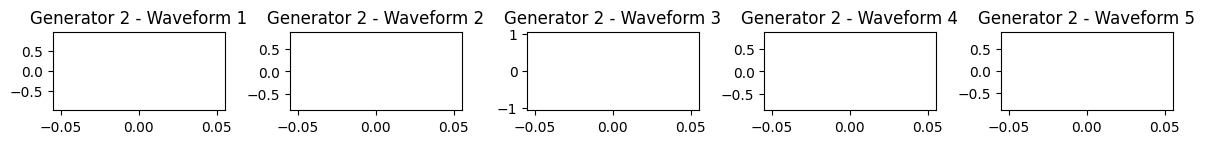

Saved waveform_mul/gen3_sample1_epoch29.wav
Saved waveform_mul/gen3_sample2_epoch29.wav
Saved waveform_mul/gen3_sample3_epoch29.wav
Saved waveform_mul/gen3_sample4_epoch29.wav
Saved waveform_mul/gen3_sample5_epoch29.wav


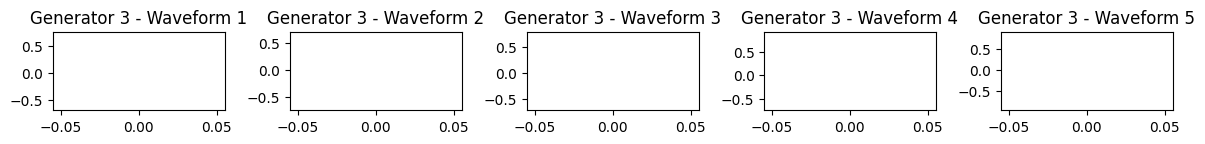

Epoch [30/200] Loss D: -6.2592
Loss G1: 5.9723
Loss G2: 6.2648
Loss G3: 6.0955
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch30.wav
Saved waveform_mul/gen1_sample2_epoch30.wav
Saved waveform_mul/gen1_sample3_epoch30.wav
Saved waveform_mul/gen1_sample4_epoch30.wav
Saved waveform_mul/gen1_sample5_epoch30.wav


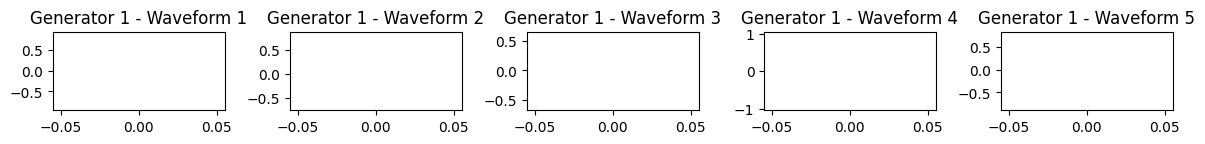

Saved waveform_mul/gen2_sample1_epoch30.wav
Saved waveform_mul/gen2_sample2_epoch30.wav
Saved waveform_mul/gen2_sample3_epoch30.wav
Saved waveform_mul/gen2_sample4_epoch30.wav
Saved waveform_mul/gen2_sample5_epoch30.wav


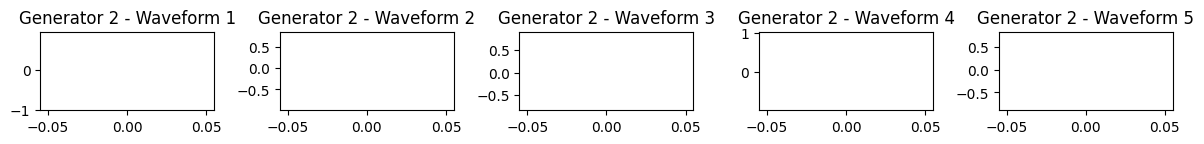

Saved waveform_mul/gen3_sample1_epoch30.wav
Saved waveform_mul/gen3_sample2_epoch30.wav
Saved waveform_mul/gen3_sample3_epoch30.wav
Saved waveform_mul/gen3_sample4_epoch30.wav
Saved waveform_mul/gen3_sample5_epoch30.wav


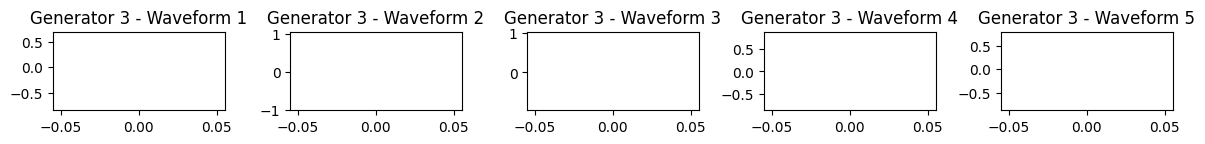

Epoch [31/200] Loss D: -6.3768
Loss G1: 6.3828
Loss G2: 6.4991
Loss G3: 6.4378
--------------------------------------------------
Saved waveform_mul/gen1_sample1_epoch31.wav
Saved waveform_mul/gen1_sample2_epoch31.wav
Saved waveform_mul/gen1_sample3_epoch31.wav
Saved waveform_mul/gen1_sample4_epoch31.wav
Saved waveform_mul/gen1_sample5_epoch31.wav


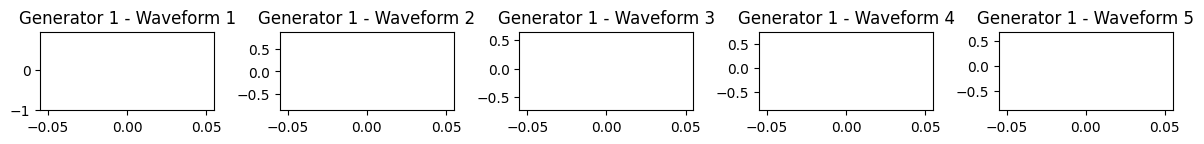

Saved waveform_mul/gen2_sample1_epoch31.wav
Saved waveform_mul/gen2_sample2_epoch31.wav
Saved waveform_mul/gen2_sample3_epoch31.wav
Saved waveform_mul/gen2_sample4_epoch31.wav
Saved waveform_mul/gen2_sample5_epoch31.wav


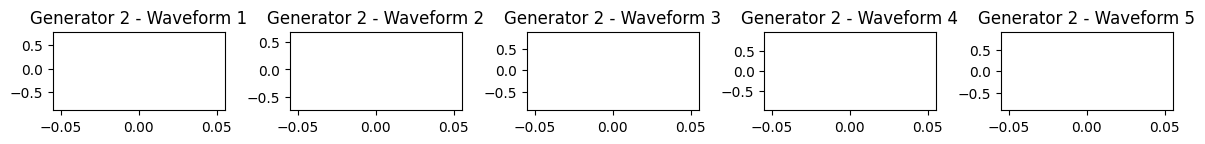

Saved waveform_mul/gen3_sample1_epoch31.wav
Saved waveform_mul/gen3_sample2_epoch31.wav
Saved waveform_mul/gen3_sample3_epoch31.wav
Saved waveform_mul/gen3_sample4_epoch31.wav
Saved waveform_mul/gen3_sample5_epoch31.wav


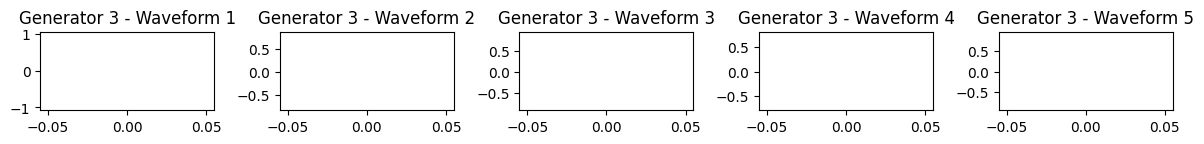

KeyboardInterrupt: 

In [ ]:
# Continue training with multiple generators initialized from the pretrained one
# train_gan_with_pretrained_generators(pretrained_generator, num_epochs=200, z_dim=100, lr_disc=0.0002, batch_size=24, num_generators=3, seed=42, lr_gen=0.0002, output_dir='waveform_mul', audio_length=64000, train_dataset = train_dataset)


In [ ]:
train_gan_with_pretrained_generators(
    pretrained_generator,
    num_epochs=200,
    z_dim=100,
    lr_gen=0.0002,
    lr_disc=0.0002,
    batch_size=32,
    train_dataset=train_dataset,
    num_generators=5,
    seed=42,
    audio_length=64000,
    output_dir='waveform_mal_2',
    checkpoint_dir='my_checkpoints',
    resume=True
)
